# Fiddle with the EAWAG scans
Look at the orientation and see if we can do some cropping based on landmarks.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import k3d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
import skimage
from tqdm.auto import tqdm, trange
import math
from numcodecs import Blosc
from skimage.segmentation import random_walker

In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [3]:
from dask.distributed import Client
client = Client()

In [4]:
client

<Client: 'tcp://127.0.0.1:36515' processes=8 threads=32, memory=125.80 GiB>

In [5]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [6]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [7]:
# Set seaborn theme
seaborn.set_theme(context='notebook', style='ticks')
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [8]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [9]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [10]:
# Different locations if running either on Linux or Windows
FastSSD = True
overthere = False  # Load the data directly from the iee-research_storage drive
nanoct = True  # Load the data directly from the 2214
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if not overthere:
    Root = os.path.join(BasePath, 'EAWAG')
else:
    Root = BasePath
# if overthere:
#         Root = os.path.join('I:\\microCTupload')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/EAWAG


In [11]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [12]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [13]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [14]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [15]:
# Get *all* log files, unsorted but fast
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [16]:
print('We found %s log files in %s' % (len(Data), Root))

We found 1260 log files in /media/habi/Fast_SSD/EAWAG


In [17]:
# Limit *all* the data to only the 'head' scans
Data = Data[Data['LogFile'].str.contains('head')]

In [18]:
print('We have %s log files with "head" in their name in %s' % ((len(Data)), Root))

We have 387 log files with "head" in their name in /media/habi/Fast_SSD/EAWAG


In [19]:
# Generate folder name
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [20]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [21]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [22]:
Data.tail()

LogFile  \
95  /media/habi/Fast_SSD/EAWAG/TJ2/head/rec/TJ2_re...   
96  /media/habi/Fast_SSD/EAWAG/TJ3/head/rec/TJ3_re...   
97  /media/habi/Fast_SSD/EAWAG/TMG15/head/rec/TMG1...   
98  /media/habi/Fast_SSD/EAWAG/TS03/head/rec/TS03_...   
99  /media/habi/Fast_SSD/EAWAG/ZuOS115/head/rec/Zu...   

                                         Folder     Fish      Scan  
95      /media/habi/Fast_SSD/EAWAG/TJ2/head/rec      TJ2  head_rec  
96      /media/habi/Fast_SSD/EAWAG/TJ3/head/rec      TJ3  head_rec  
97    /media/habi/Fast_SSD/EAWAG/TMG15/head/rec    TMG15  head_rec  
98     /media/habi/Fast_SSD/EAWAG/TS03/head/rec     TS03  head_rec  
99  /media/habi/Fast_SSD/EAWAG/ZuOS115/head/rec  ZuOS115  head_rec

In [23]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [[os.path.join(root, name)
                            for root, dirs, files in os.walk(f)
                            for name in files
                            if 'rec0' in name and name.endswith((".png"))] for f in Data['Folder']]
# Count how many files we have
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [24]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c, row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions in %s' % ((len(Data)), Root))

We have 97 folders with reconstructions in /media/habi/Fast_SSD/EAWAG


In [25]:
# Get parameters we need from the log files
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [26]:
# Load all reconstructions into DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/97 [00:00<?, ?it/s]

In [27]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [28]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [29]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [30]:
# Read in previously generated MIPs or calculate them
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(), desc='Calculating MIPs', total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s: %s' % (row['Fish'], row['Scan'], direction),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute().squeeze()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

Calculating MIPs:   0%|          | 0/97 [00:00<?, ?it/s]

10151/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103375/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103571/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103635/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103704/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103718/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103723/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103754/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103761/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103767/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103767/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103778/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

103908/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104021/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104061/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10448/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10448/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104621/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104671/head_rec2: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104856/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104929/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10605/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10618/head_head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10618/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_2xbin_23um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_4xbin_40um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10619/head_rec_unbinned_17.5um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_13um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10628/head_18um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10629/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

106641/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

106816/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10791/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

10794/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109188/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109209/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109220/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

109320/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11053/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11116/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11116/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11322/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11344/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11447/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11500/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11557/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11601/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11729/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11807/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11807/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11946/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11965/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11965/rec_head_40um: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11992/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12319/head_30um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12319/head_50um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

12807/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13069/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13115/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

131282/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13393/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

13492/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

14298/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

156645/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

158795/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

158816/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

161476/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

161543/head_30um_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22406/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22476/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

22476/head2_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

AN33/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

BH58/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104016/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

11639/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

14295/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG104/head_rec_head: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG142/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG156/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG161/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG75/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG80/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG92/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

IG96/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

JU22/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

KAT13/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

KC31/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

MA31/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

NA4/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

NY75/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TJ2/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TJ3/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TMG15/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

TS03/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

ZuOS115/head_rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
# Collect views
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of MIP images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        print('%s/%s: %s' % (c, len(Data), os.path.join(row.Fish, row.Scan)))
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Fish'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s MIP' % direction)
            plt.axis('off')
            plt.title('%s\n%s MIP' % (os.path.join(row['Fish'], row['Scan']), direction))
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

Saving overview of MIP images:   0%|          | 0/97 [00:00<?, ?it/s]

The functions below were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [32]:
# From Hearts-Melly/SubMyocardAnalysis.ipynb
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return(properties)

In [33]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert(labels.max() != 0)  # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:]) + 1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [34]:
def threshold(image, verbose=False):
    # Calculate threshold of image where image is non-zero
    threshold = skimage.filters.threshold_otsu(image[image > 0])
    if verbose:
        plt.subplot(121)
        plt.imshow(image)
        plt.imshow(dask.array.ma.masked_equal(image > threshold, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.subplot(122)
        plt.semilogy(histogram(image), label='Log-Histogram')
        plt.axvline(threshold, label='Otsu threshold: %s' % threshold)
        plt.legend()
        plt.show()
    return(threshold)

In [35]:
# Calculate the histogram of an image
# We can safely assume to only use 8bit images
def histogram(img):
    histogram, bins = dask.array.histogram(dask.array.array(img),
                                           bins=2**8,
                                           range=[0, 2**8])
    return(histogram)

In [36]:
whichone = 4
print(os.path.join(Data.Fish[whichone], Data.Scan[whichone]))
img = dask.array.asarray(Data.MIP_Anteroposterior[whichone])

103704/head_rec


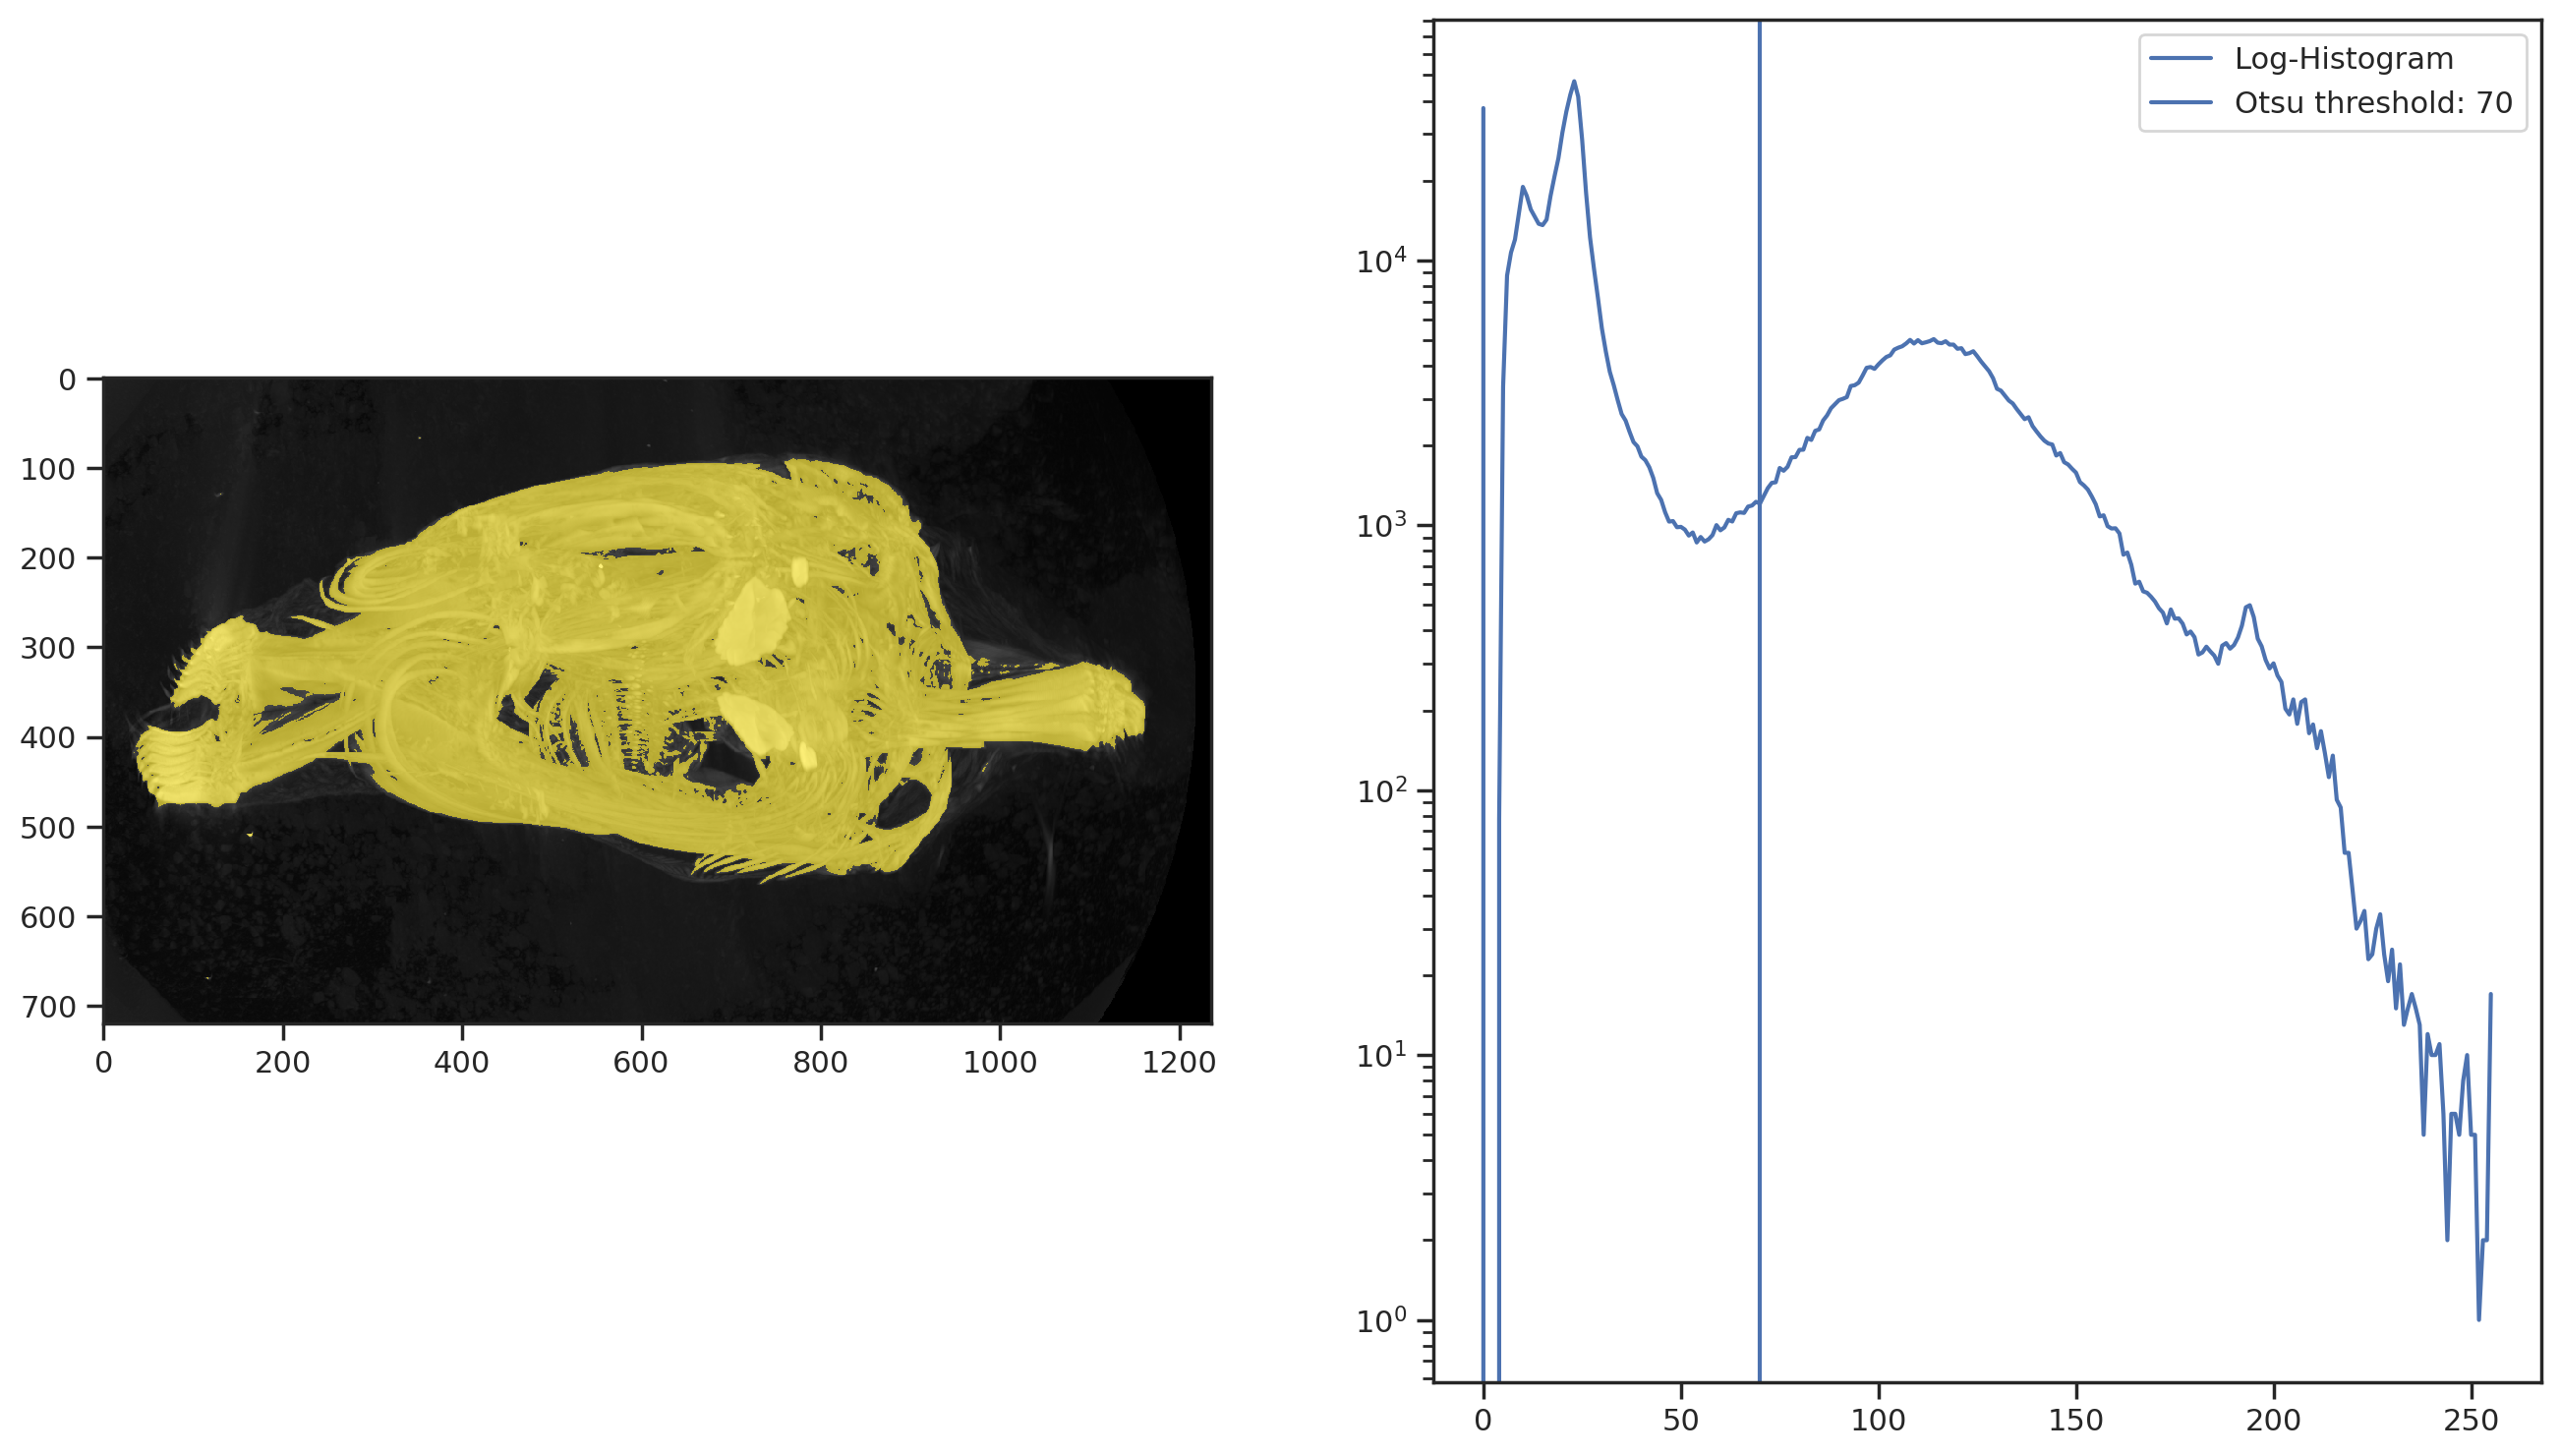

In [37]:
t = threshold(img.compute(), verbose=True)

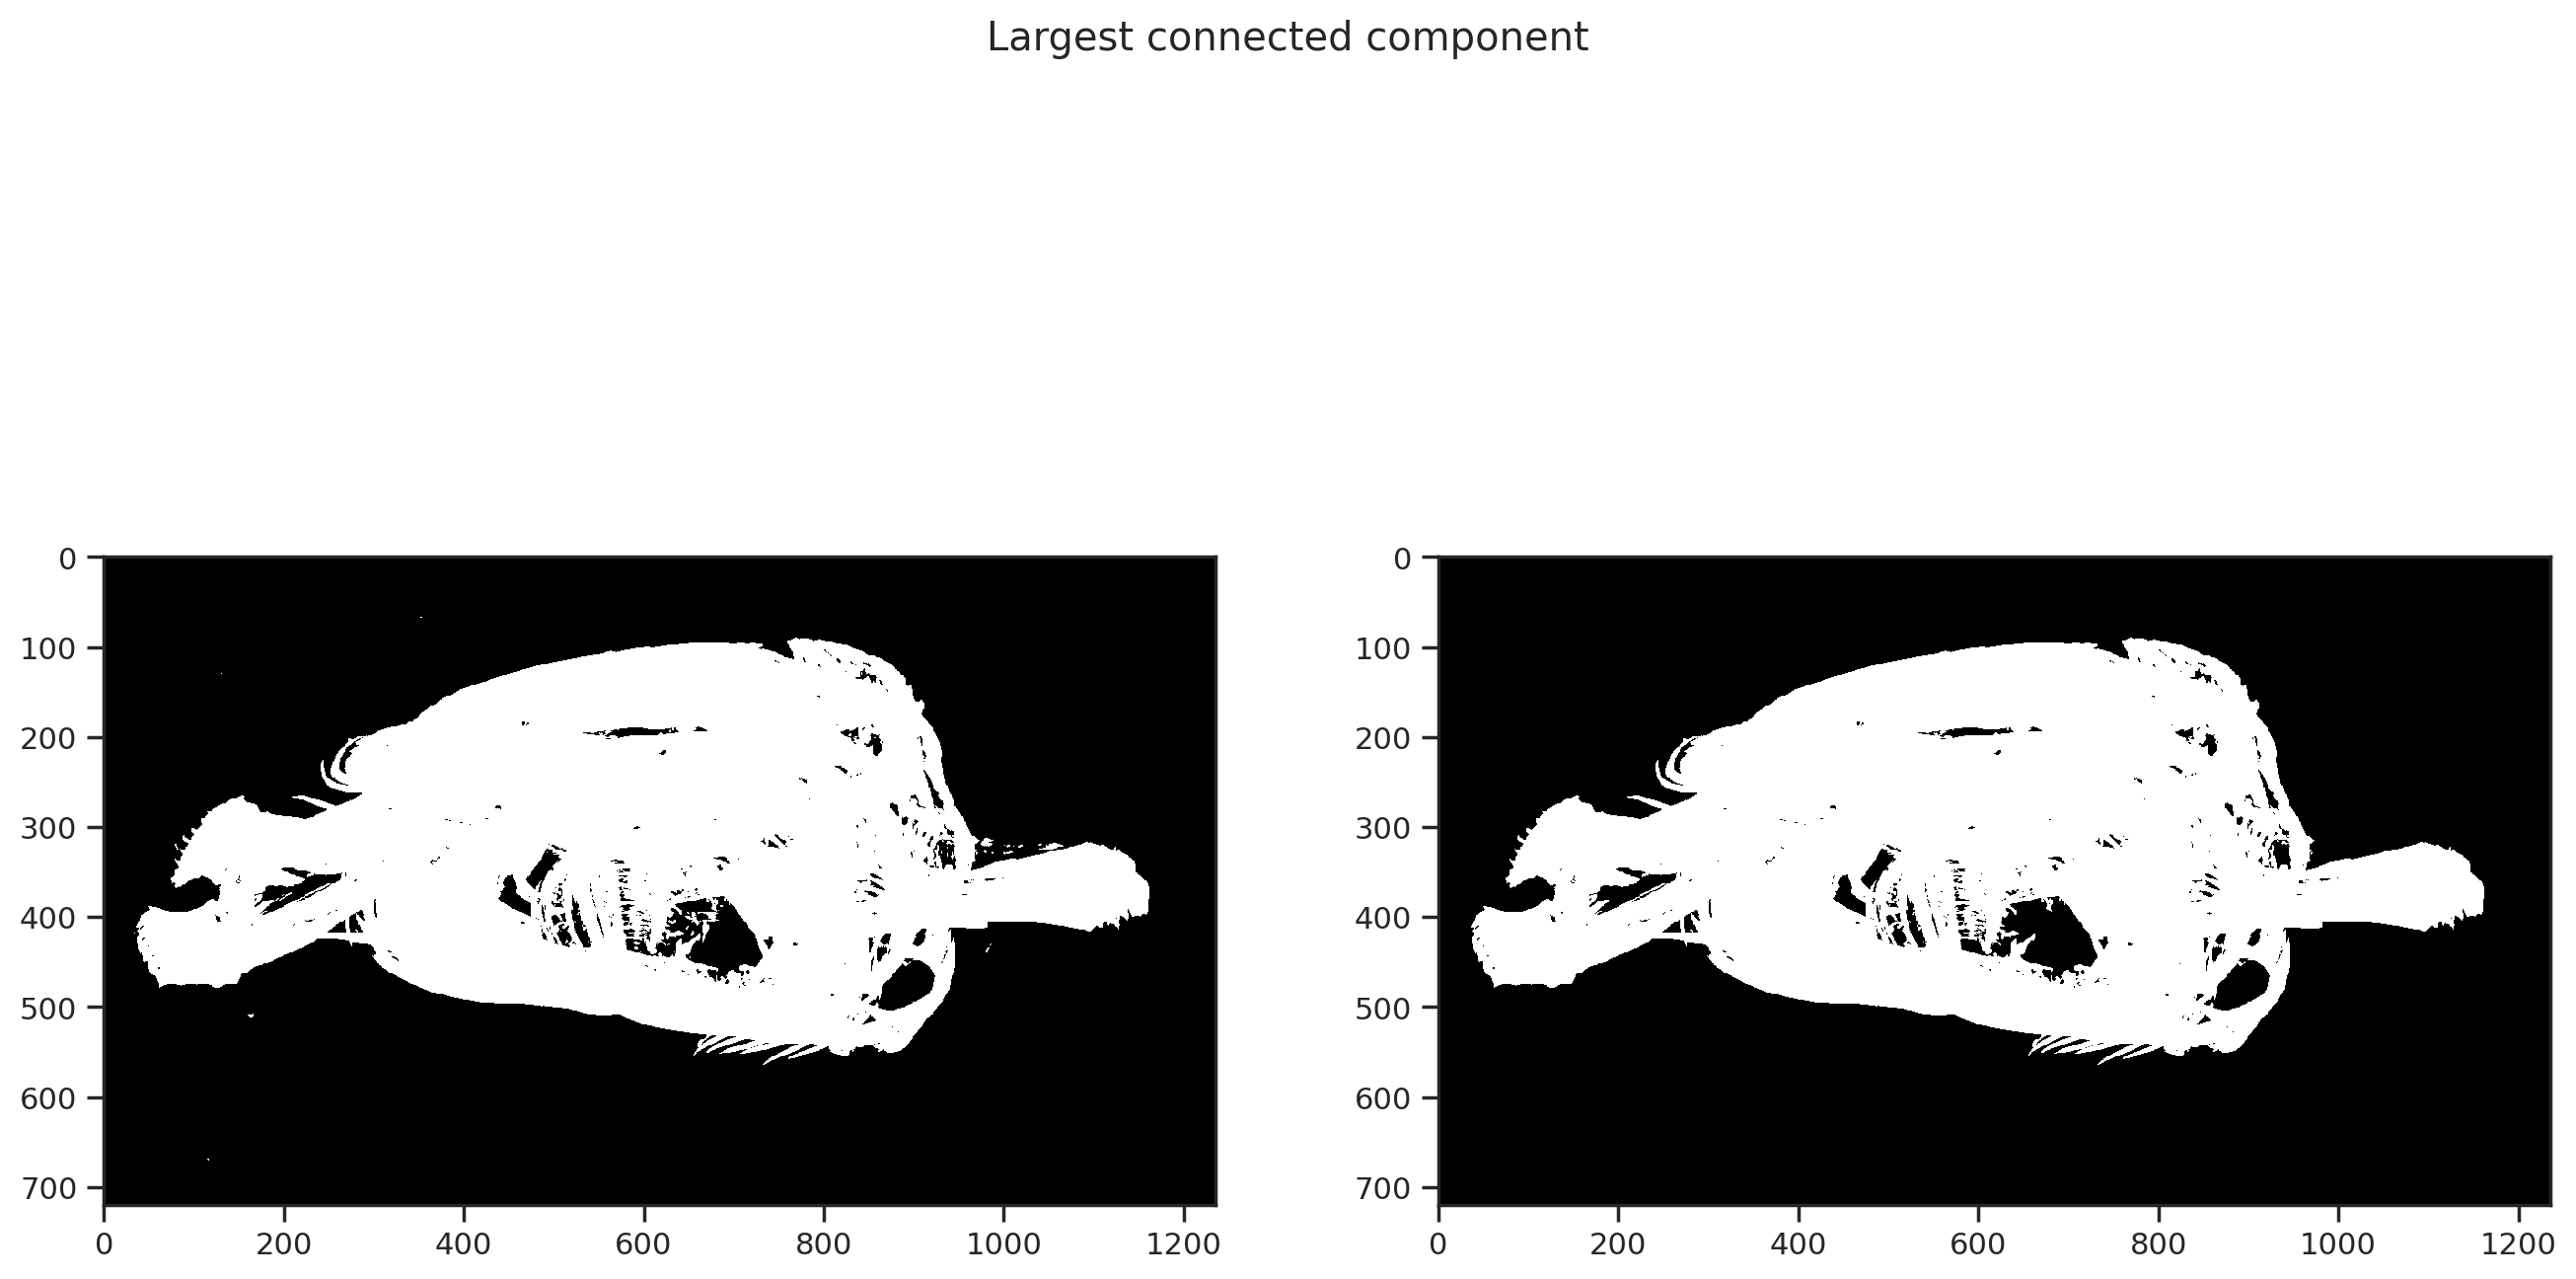

In [38]:
a = get_largest_region(img > t, verbose=True)

In [39]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return((x0, y0))

In [40]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=False)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return(cx, cy)

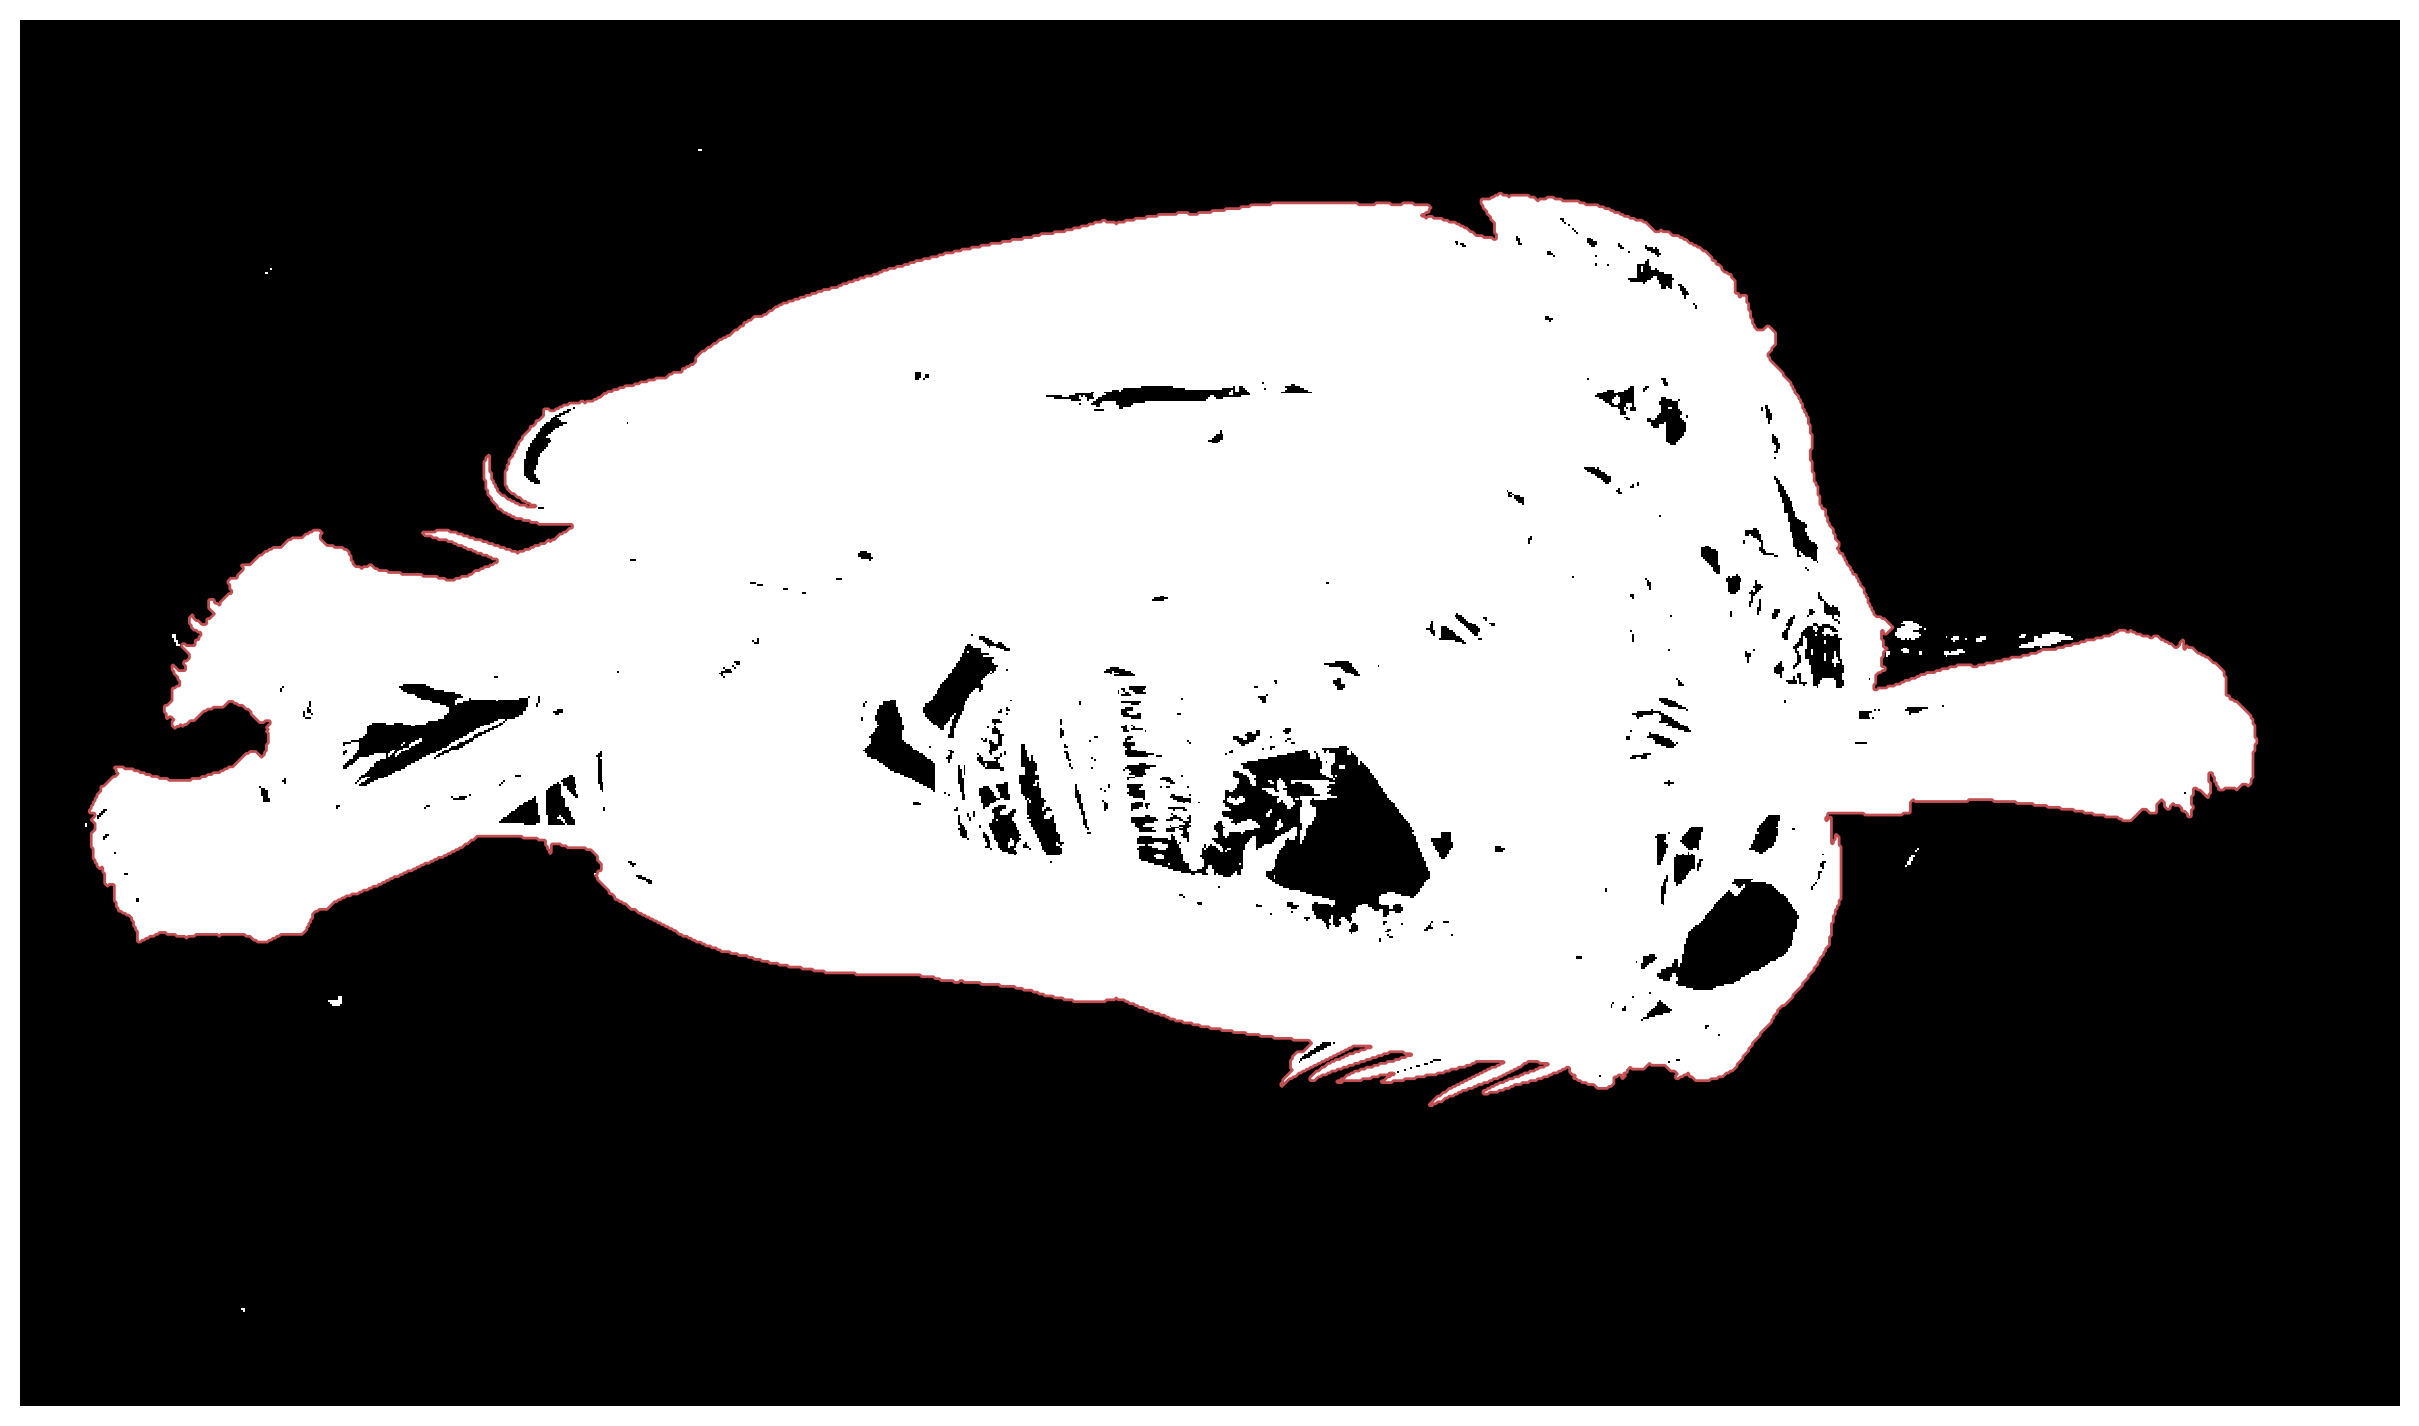

In [41]:
contour = get_contour(img > t, verbose=True)

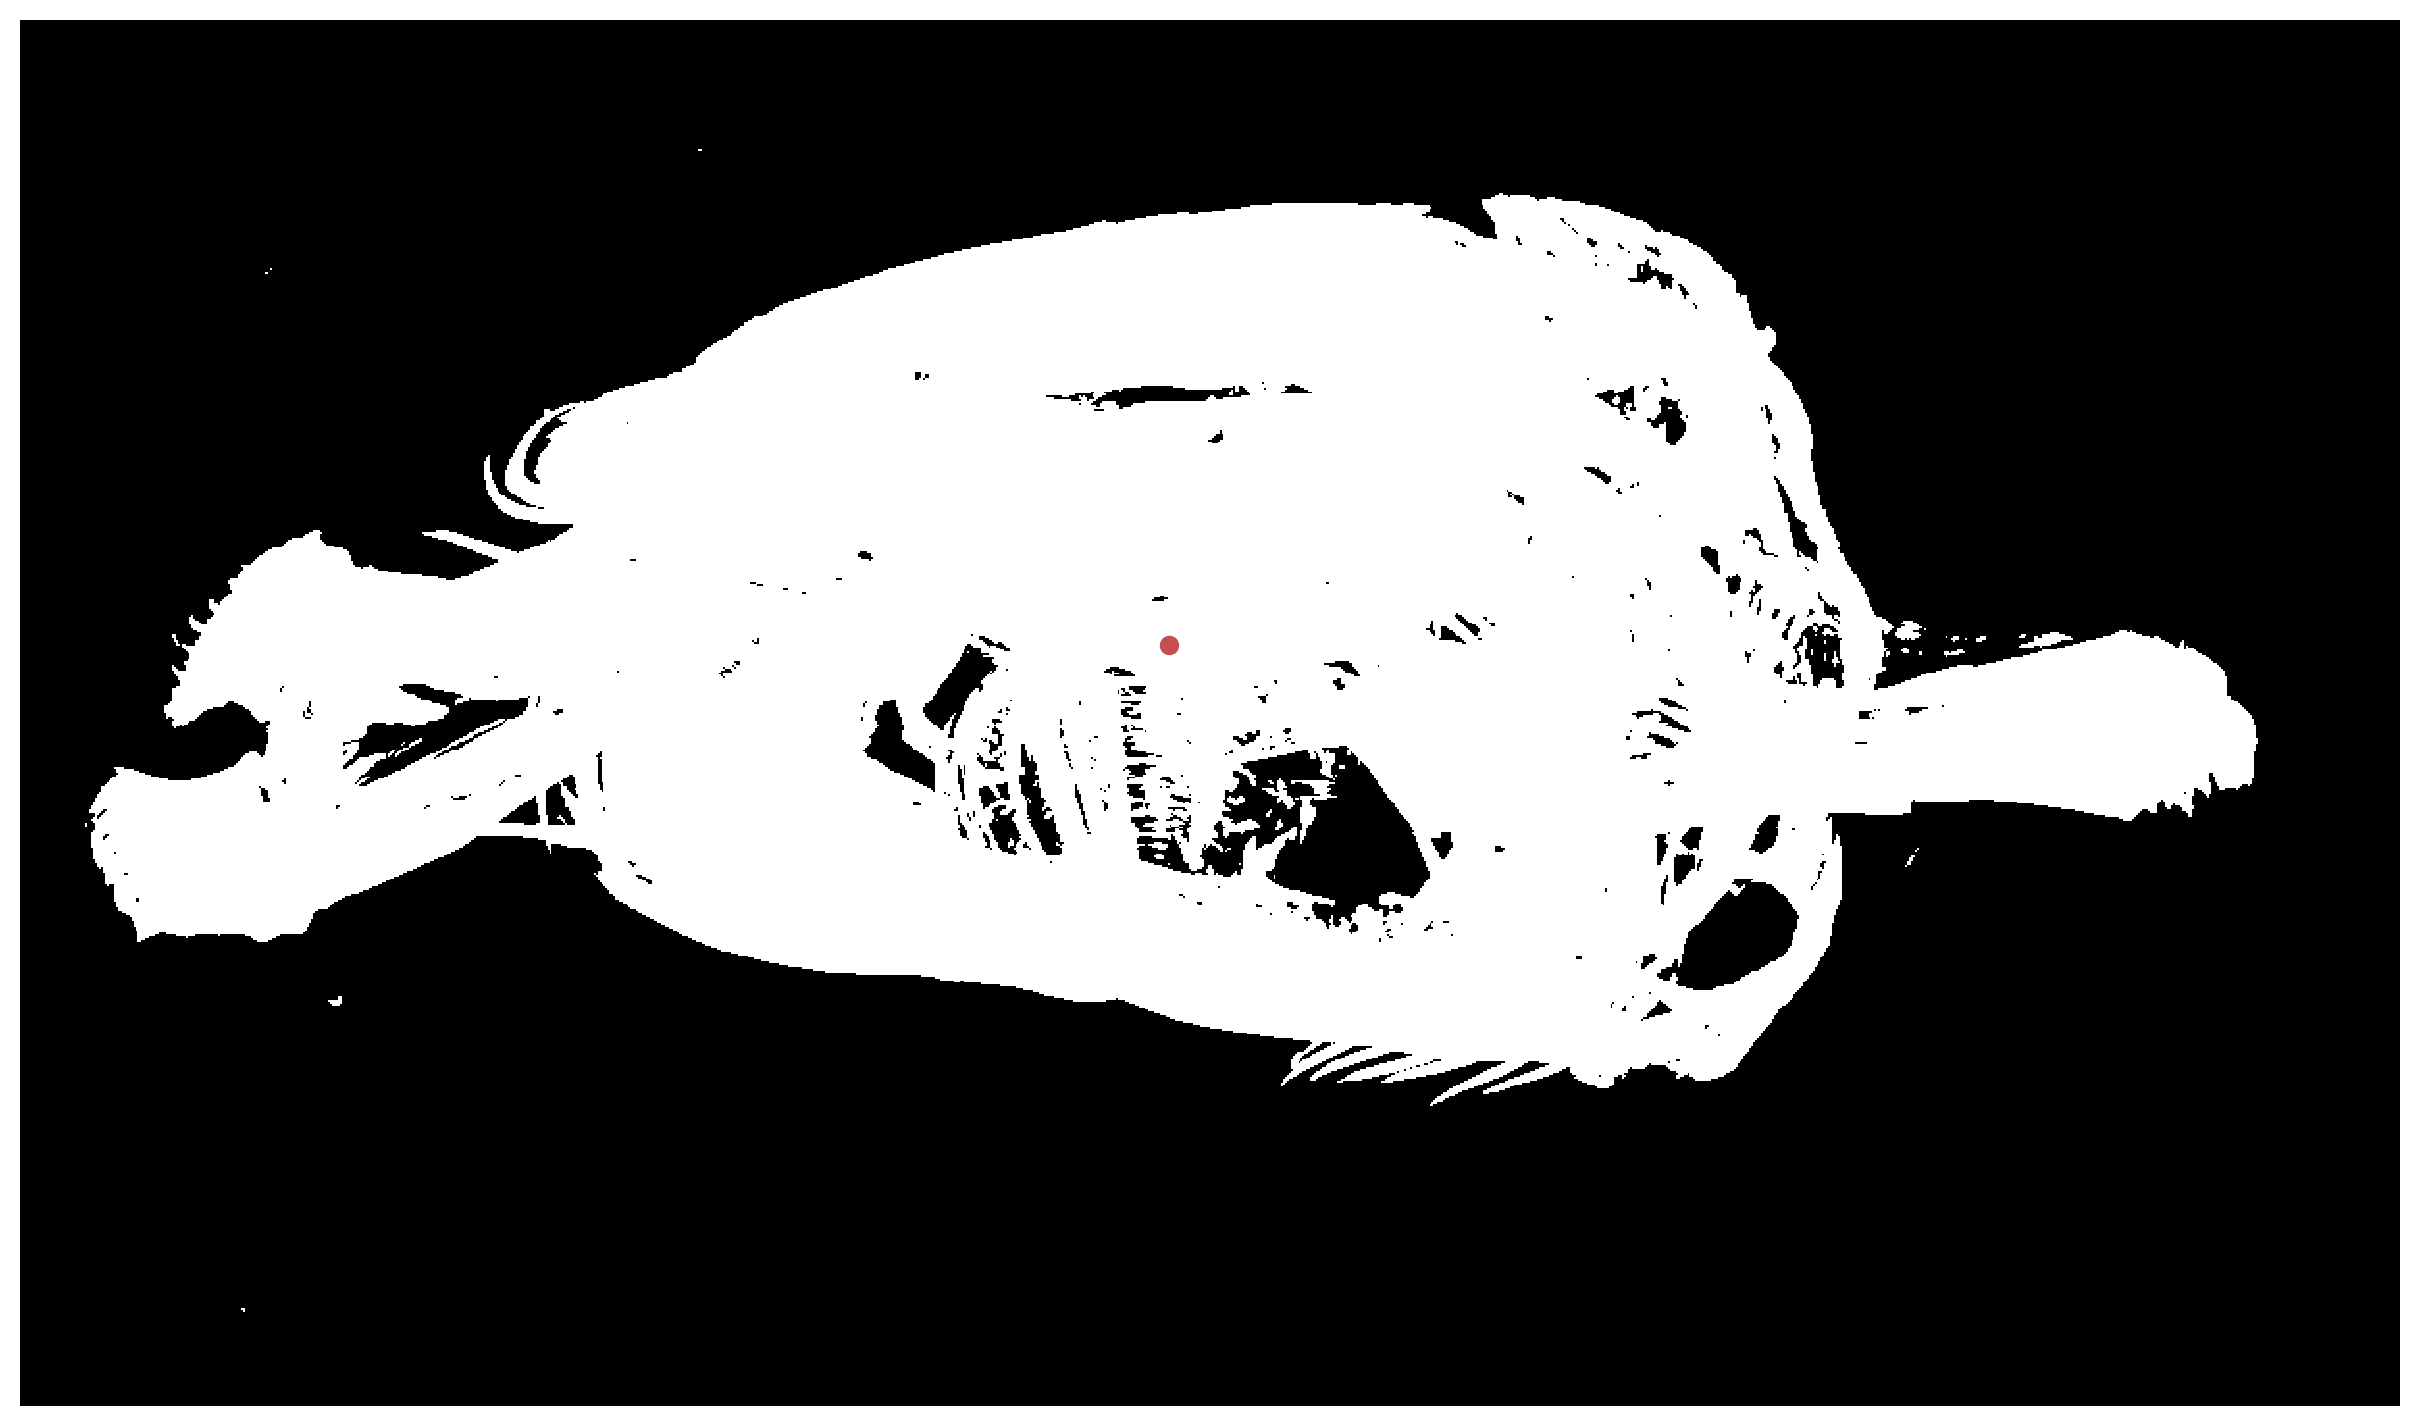

In [42]:
centroid = get_centroid(img > t, verbose=True)

In [43]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return()

In [44]:
def get_orientation(img, voxelsize, length=10, verbose=False):
    '''
    Get and draw orientation onto image, with a (default) length of 10 mm
    '''
    props = get_properties(img)
    whichlengthdowewant = length
    reallength = whichlengthdowewant / voxelsize * 1000  # mm
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation']) * reallength
    y1 = y0 - math.sin(props['orientation']) * reallength
    x2 = x0 - math.sin(props['orientation']) * reallength
    y2 = y0 - math.cos(props['orientation']) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s mm long orientation bars' % length)
        plt.show()
    return(x0, x1, x2, y0, y1, y2)

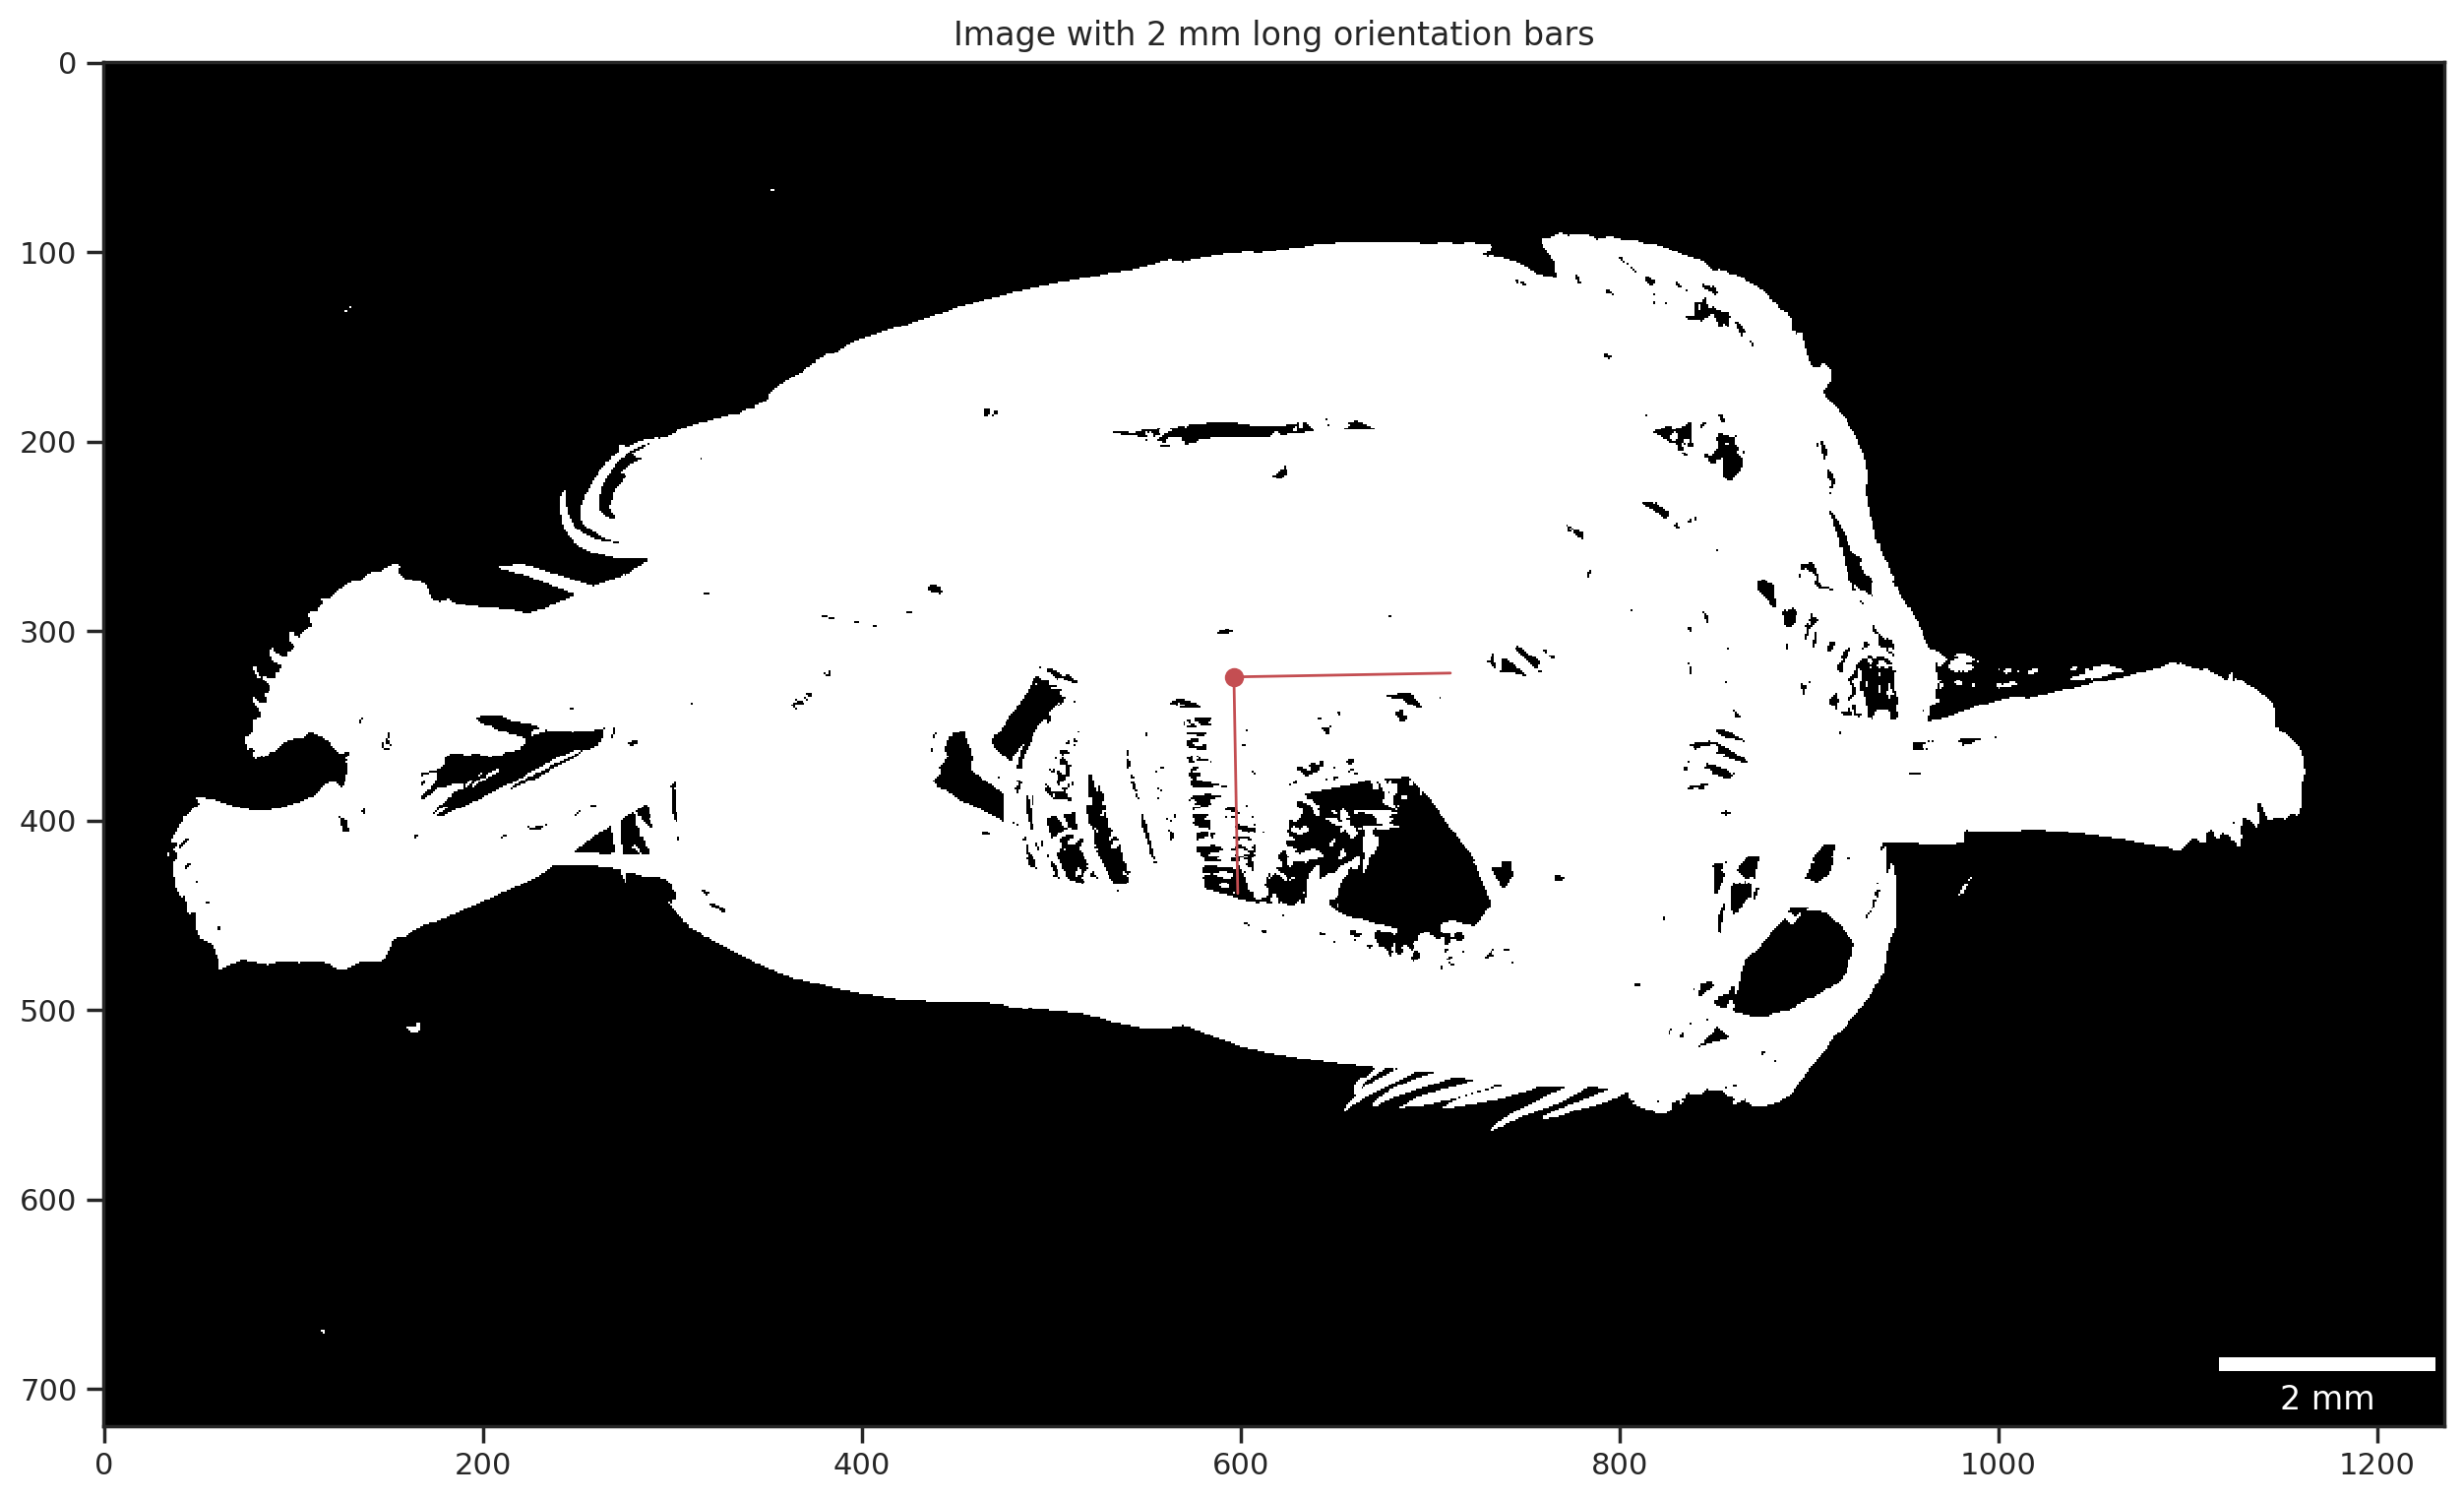

In [45]:
x0, x1, x2, y0, y1, y2 = get_orientation(img > t,
                                         Data.Voxelsize[4],
                                         length=2,
                                         verbose=True)

The functions above were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [46]:
a = get_properties(img > t)
print(a)

   index  label  centroid-0  centroid-1    area     perimeter  orientation
0      1      2  324.253949  596.418522  291397  11580.966948    -1.552971


In [47]:
# Use the angle and centroid to rotate image
img_rotated = numpy.empty_like(img)
img_rotated = skimage.transform.rotate(img.compute(),
                                       angle=numpy.rad2deg(a.orientation[0]),
                                       center=(a['centroid-0'][0], a['centroid-1'][0]),
                                       preserve_range=True)

In [48]:
numpy.rad2deg(a.orientation[0])+90

1.0212998747194888

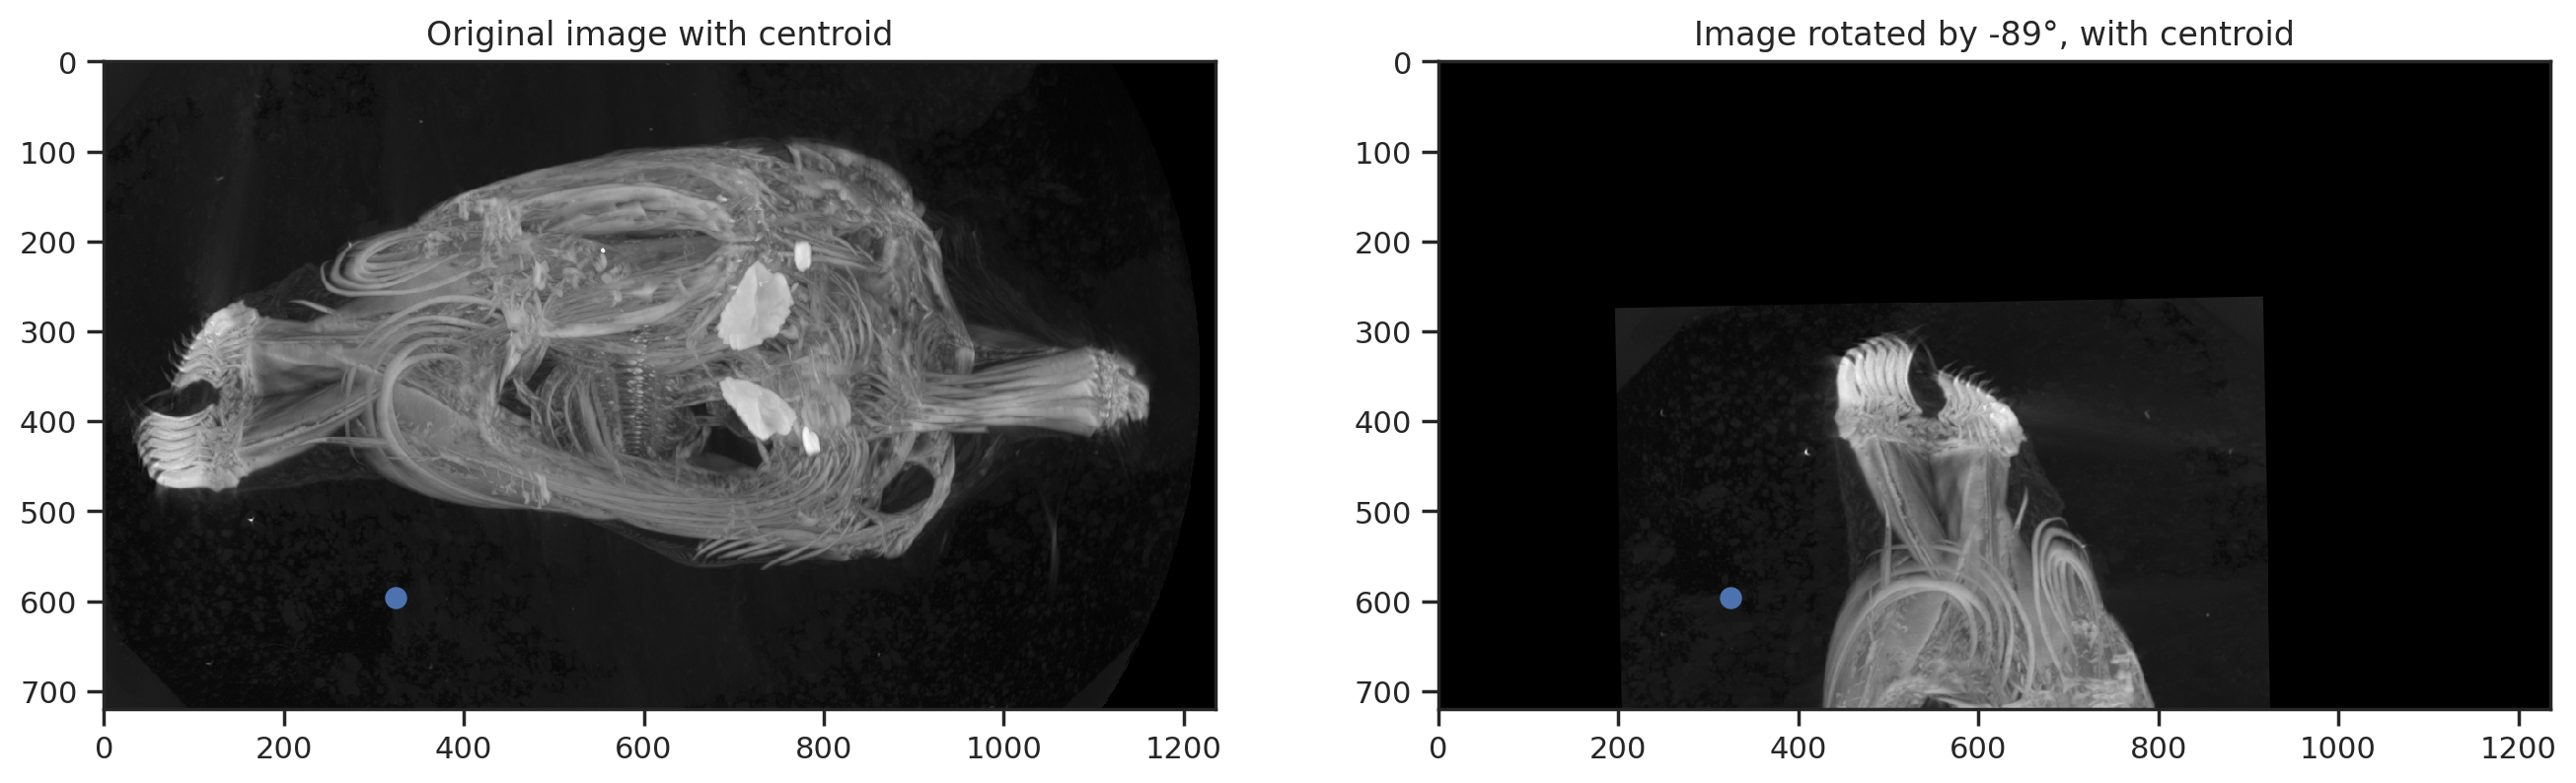

In [49]:
# Let's show what we did
plt.subplot(121)
plt.imshow(img)
plt.scatter(a['centroid-0'], a['centroid-1'], s=50)
plt.title('Original image with centroid')
plt.subplot(122)
plt.imshow(img_rotated)
plt.scatter(a['centroid-0'], a['centroid-1'], s=50)
plt.title('Image rotated by %0.f°, with centroid' % numpy.rad2deg(a.orientation[0]))
plt.show()

Figure out the otolith position on each of the directional views.

In [50]:
def smoother(curve, frac=0.1):
    ''' Smooth a curve '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=frac)
    return(smoothed)

In [51]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    minimal_diff = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(minimal_diff, c='r', label='Border')
        plt.legend()
    return(minimal_diff)

In [52]:
def get_maximum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    maximal_diff = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(maximal_diff, c='r', label='Border')
        plt.legend()
    return(maximal_diff)

In [53]:
def get_peak(curve, start=None, stop=None, frac=0.25, height=0.25, verbose=False):
    ''' Find a peak in the smoothed curve '''
    # Peak finding from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    # Mask a bit at the start and a bit start and end of curve, if desired
    mask = dask.array.zeros_like(curve)
    if start:
        mask[:start] = 1
    if stop:
        mask[stop:] = 1
    if start or stop:
        original_curve = curve
        smoothed = smoother(dask.array.ma.filled(dask.array.ma.masked_where(mask, curve), fill_value=0),
                            frac=frac)
    else:
        smoothed = smoother(curve, frac=frac)
    if verbose:
        print('The input curve has a length of %s' % len(curve))
        if start:
            print('We discard the %s values from the start' % start)
        if stop:
            print('We discard the values from %s to the end' % stop)            
        print('The input to the smoother has a length of %s' % (len(mask) - dask.array.count_nonzero(mask)).compute())
    peak, _ = scipy.signal.find_peaks(smoothed, width=100)    
    peak_value = dask.array.asarray(smoothed[peak])
    # Peak width from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html
    results_width = scipy.signal.peak_widths(smoothed, peak, rel_height=height)
    if len(peak) > 1:
        # Return only 'higher' peak if we have several
        peak = dask.array.asarray(peak[dask.array.argmax(peak_value)])
        results_width = [item[dask.array.argmax(peak_value)] for item in results_width]
        peak_value = int(peak_value[dask.array.argmax(peak_value)])
    # Get actual width
    width = results_width[0]
    # if start:
    #     peak = peak + start
    #     results_width = [v[0]+start for v in results_width]
    if verbose:
        if start or stop:
            plt.plot(original_curve, alpha=0.618, label='Original')
        plt.plot(dask.array.ma.masked_where(mask, curve), label='Input')
        plt.plot(smoothed, label='Smoothed (frac=%s)' % frac)
        plt.plot(peak,
                 smoothed[peak],
                 'x',
                 color='C2',
                 label='Peak@%s' % int(peak))
        plt.hlines(*results_width[1:],
                   color="C3",
                   label='Peak width at %d%%: %s' % (100*height, int(width)))
        plt.legend()
        # plt.xlim([0,len(curve)])
        plt.show()

    return(int(peak), int(peak_value), int(width))

In [54]:
# Put gray values of one fish in lists, so we can fiddle with them
whichone = 19
gv =  [None] * len(directions) 
gh =  [None] * len(directions) 
for c, direction in enumerate(directions):
    gv[c] = Reconstructions[whichone].max(axis=c).sum(axis=0)
    gh[c] = Reconstructions[whichone].max(axis=c).sum(axis=1)

In [55]:
# One peak for testing
# get_peak(gv[1], start=100, stop=1111, verbose=True)

In [56]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly. From https://stackoverflow.com/a/50011743/323100"""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [57]:
def get_grayvalues(image, plane, which):
    ''' get grayvalue along horizontal or vertical image plane '''
    grayvalues = []
    if plane == 'horizontal':
        ax = 0
    elif plane == 'vertical':
        ax = 1
    else:
        print('No plane given, specify either "plane=horizontal" or "plane=vertical"')
        print('Returning EMPTY grayvalues')        
        return(grayvalues)
    if which == 'sum':
        grayvalues = image.sum(axis=ax)
    elif which == 'max':
        grayvalues = image.max(axis=ax)
    else:
        print('No method given, specify either "which=max" or "which=sum"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    return(grayvalues)

In [58]:
for dir in directions:
    print(dir)

Anteroposterior
Lateral
Dorsoventral


In [59]:
planes = ['horizontal', 'vertical']

In [60]:
# Generate empty columns to fill in the values we calculate below
Data['Otolith_Sphere_Diameter_fish'] = '' # Merged peak position
for c, direction in enumerate(directions):
    Data['Discard_' + direction + '_fish'] = '' # General discard directions
    Data['Otolith_Peak_' + direction + '_fish'] = '' # Merged peak position
    Data['Otolith_Width_' + direction + '_fish'] = '' # Merged peak position
    for plane in planes:
        Data['Discard_' + direction + '_image_' + plane] = '' # Copy the general discard values to the ones we need for each image
        Data['Otolith_Peak_'  + direction + '_' + plane] = ''
        Data['Otolith_Width_' + direction + '_' + plane] = ''
        Data['Grayvalues_'    + direction + '_' + plane] = ''

In [550]:
def otolither_region(whichone, discard_front=None, bottom=1000, showregion=True, verbose=False):
    '''
    Modeled after algorithm for finding the enamel/dentin border for the tooth project (https://github.com/habi/zmk-tooth-cohort/blob/master/ToothAnalysis.ipynb), we
    look for a change and bump in the gray values along different axis of the fishes.
    This works out nicely to detect the approximate region of the otoliths.
    '''
    if verbose:
        print('We try to find the otholith for the %s scan of fish %s' % (Data.Scan[whichone], Data.Fish[whichone]))
    
    # Discard some regions of the images for finding the otoliths
    # frontally: contains the teeth
    # back: can contain labels or dorsal fins
    Data.at[whichone, 'Discard_Anteroposterior_fish'] = [round(Data.MIP_Lateral[whichone].shape[0] / 5),
                                                         round(Data.MIP_Lateral[whichone].shape[0] - Data.MIP_Lateral[whichone].shape[0] / 5)]
    # laterally otoliths are in the middle of the fish    
    Data.at[whichone, 'Discard_Lateral_fish'] = [round(Data.MIP_Dorsoventral[whichone].shape[1] / 8),
                                                 round(Data.MIP_Dorsoventral[whichone].shape[1] - Data.MIP_Dorsoventral[whichone].shape[1] / 8)]
    # bottom: a lot of the fish, no otolith
    # top: often empty
    Data.at[whichone, 'Discard_Dorsoventral_fish'] = [round(Data.MIP_Anteroposterior[whichone].shape[1] / 4),
                                                      round(Data.MIP_Anteroposterior[whichone].shape[1] - Data.MIP_Anteroposterior[whichone].shape[1] / 10)]
    
    # Copy the discard values to different planar directions for every image.
    # This is *very* hacky, but makes it all run in one single loop
    Data.at[whichone, 'Discard_Anteroposterior_image_horizontal'] = Data['Discard_Dorsoventral_fish'][whichone]
    Data.at[whichone, 'Discard_Anteroposterior_image_vertical']   = Data['Discard_Lateral_fish'][whichone]
    Data.at[whichone, 'Discard_Lateral_image_horizontal']         = Data['Discard_Dorsoventral_fish'][whichone]
    Data.at[whichone, 'Discard_Lateral_image_vertical']           = Data['Discard_Anteroposterior_fish'][whichone]
    Data.at[whichone, 'Discard_Dorsoventral_image_horizontal']    = Data['Discard_Lateral_fish'][whichone]
    Data.at[whichone, 'Discard_Dorsoventral_image_vertical']      = Data['Discard_Anteroposterior_fish'][whichone]    

    if verbose:
        print('We discard the ventral %s and the dorsal %s slices of the fish' % (Data['Discard_Dorsoventral_fish'][whichone][0], Data['Discard_Dorsoventral_fish'][whichone][1]))
        print('We discard the anterior %s and the posterior %s slices of the fish' % (Data['Discard_Anteroposterior_fish'][whichone][0], Data['Discard_Anteroposterior_fish'][whichone][1]))
        print('We discard the fish laterally between slices %s and %s' % (Data['Discard_Lateral_fish'][whichone][0], Data['Discard_Lateral_fish'][whichone][1]))

    for direction in directions:
        for plane in planes:
            if verbose:
                print('Calculating Grayvalues_' + direction + '_' + plane)
            if ('Dorso' not in direction) and ('hor' in plane):
                method = 'sum'
            else:
                method = 'sum'
            Data.at[whichone, 'Grayvalues_' + direction + '_' + plane] = get_grayvalues(Data['MIP_' + direction][whichone],
                                                                                        plane=plane,
                                                                                        which=method)            
                                                                                        # which='sum')            
            # Our peak finder function returns peak position, peak value and peak width
            # We only need position and width and don't save the value (for now)
            if verbose:
                print(80*'-')
                print(direction, plane)
                print('GV length', len(Data['Grayvalues_' + direction + '_' + plane][whichone]))
                print('For %s/%s we want to discard %s' % (direction, plane, Data.at[whichone, 'Discard_' + direction + '_image_' + plane]))
                print('MIP shape', Data['MIP_' + direction][whichone].shape)

                print(80*'-')
            height = 0.2
            frac = 0.1
            if ('Ant' in direction) and ('vert' in plane):
                height=0.5
            # elif ('Ant' in direction) and ('hor' in plane):
            #     frac=0.5
            #     height=0.25                
            # elif ('Lat' in direction) and ('vert' in plane):
            #     height=0.2             
            elif ('Lat' in direction) and ('hor' in plane):
                frac=0.5
                height=0.309           
            elif ('Dors' in direction) and ('vert' in plane):
                height=0.15
            elif ('Dors' in direction) and ('hor' in plane):
                height=0.5                
            # else:
            #     pass
            peak, _, width = get_peak(Data['Grayvalues_' + direction + '_' + plane][whichone],
                                      start=Data['Discard_'+ direction + '_image_' + plane][whichone][0],
                                      stop=Data['Discard_'+ direction + '_image_' + plane][whichone][1],
                                      frac=frac,
                                      height=height,
                                      verbose=verbose)
            Data.at[whichone, 'Otolith_Peak_' + direction + '_' + plane] = peak
            Data.at[whichone, 'Otolith_Width_' + direction + '_' + plane] = width
            
    # Calculate means found values, to be applied as cutout region
    Data.at[whichone,'Otolith_Peak_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_vertical'][whichone],
                                                                                  Data['Otolith_Peak_Lateral_vertical'][whichone]))))
    Data.at[whichone,'Otolith_Width_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_vertical'][whichone],
                                                                                  Data['Otolith_Width_Lateral_vertical'][whichone]))))
    Data.at[whichone,'Otolith_Peak_Lateral_fish']         = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_horizontal'][whichone],
                                                                                  Data['Otolith_Peak_Anteroposterior_vertical'][whichone]))))
    Data.at[whichone,'Otolith_Width_Lateral_fish']         = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_horizontal'][whichone],
                                                                                  Data['Otolith_Width_Anteroposterior_vertical'][whichone]))))
    Data.at[whichone,'Otolith_Peak_Dorsoventral_fish']    = int(round(numpy.mean((Data['Otolith_Peak_Anteroposterior_horizontal'][whichone],
                                                                                  Data['Otolith_Peak_Lateral_horizontal'][whichone]))))            
    Data.at[whichone,'Otolith_Width_Dorsoventral_fish']    = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_horizontal'][whichone],
                                                                                  Data['Otolith_Width_Lateral_horizontal'][whichone]))))                
    Data.at[whichone,'Otolith_Sphere_Diameter_fish'] = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_fish'][whichone],
                                                                             Data['Otolith_Width_Lateral_fish'][whichone],
                                                                             Data['Otolith_Width_Dorsoventral_fish'][whichone]))))
    return()

In [551]:
Data['Otolith_Width_Dorsoventral_horizontal'][whichone]

516

In [560]:
whichone = 55

In [561]:
otolither_region(whichone, verbose=False)

()

In [568]:
def display_otolith_position(whichone):
    # Display everything
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3)
    for c, direction in enumerate(directions):
        mip = fig.add_subplot(gs[0, c])
        # Show image
        plt.imshow(Data['MIP_' + direction][whichone])
        
        # # Show discarded regions
        # if not 'Dorsoventral' in direction:
        #     plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
        #                       0, Data['Discard_Dorsoventral_fish'][whichone][0],
        #                       alpha=0.309, label='discarded up to %s' % Data['Discard_Dorsoventral_fish'][whichone][0],
        #                       color=seaborn.color_palette()[2])
        #     plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
        #                       Data['Discard_Dorsoventral_fish'][whichone][1], Data['MIP_' + direction][whichone].shape[1] - 1,
        #                       alpha=0.309, label='discarded from %s' % Data['Discard_Dorsoventral_fish'][whichone][1],
        #                       color=seaborn.color_palette()[2])            
        # else:
        #     plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
        #                       0, Data['Discard_Lateral_fish'][whichone][0],
        #                       alpha=0.309, label='discarded up to %s' % Data['Discard_Lateral_fish'][whichone][0],
        #                       color=seaborn.color_palette()[1])
        #     plt.fill_betweenx(range(Data['MIP_' + direction][whichone].shape[0]),
        #                       Data['Discard_Lateral_fish'][whichone][1], Data['MIP_' + direction][whichone].shape[1] - 1,
        #                       alpha=0.309, label='discarded from %s' % Data['Discard_Lateral_fish'][whichone][1],
        #                       color=seaborn.color_palette()[1])
        # if 'Ante' not in direction:
        #     plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
        #                      0,
        #                      Data['Discard_Anteroposterior_fish'][whichone][0],
        #                      alpha=0.309, label='discarded from %s' % Data['Discard_Anteroposterior_fish'][whichone][0],
        #                      color=seaborn.color_palette()[0])
        #     plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
        #                      Data['Discard_Anteroposterior_fish'][whichone][1],
        #                      Data['MIP_' + direction][whichone].shape[0] - 1,
        #                      alpha=0.309, label='discarded from %s' % Data['Discard_Anteroposterior_fish'][whichone][1],
        #                      color=seaborn.color_palette()[0])
        # else:
        #     plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
        #                      0,
        #                      Data['Discard_Lateral_fish'][whichone][0],
        #                      alpha=0.309, label='discarded from %s' % Data['Discard_Lateral_fish'][whichone][0],
        #                      color=seaborn.color_palette()[1])
        #     plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
        #                      Data['Discard_Lateral_fish'][whichone][1],
        #                      Data['MIP_' + direction][whichone].shape[0] - 1,
        #                      alpha=0.309, label='discarded from %s' % Data['Discard_Lateral_fish'][whichone][1],
        #                      color=seaborn.color_palette()[1])
        
        # *Very* verbose way of drawing the region we look at
        # But since we have all the values, we can easily put them where we want
        # Rectangle(xy, width, height)
        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Discard_' + direction + '_image_horizontal'][whichone][0],
                                                          Data['Discard_' + direction + '_image_vertical'][whichone][0]),
                                                         Data['MIP_' + direction][whichone].shape[1] - (Data['MIP_' + direction][whichone].shape[1] - Data['Discard_' + direction + '_image_horizontal'][whichone][1]) - Data['Discard_' + direction + '_image_horizontal'][whichone][0],
                                                         Data['MIP_' + direction][whichone].shape[0] - (Data['MIP_' + direction][whichone].shape[0] - Data['Discard_' + direction + '_image_vertical'][whichone][1]) - Data['Discard_' + direction + '_image_vertical'][whichone][0],
                                                         edgecolor=seaborn.color_palette()[c],
                                                         facecolor='none',
                                                         label='Region for detection'))
        
        # Plot gray values onto the image
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichone], 0, Data['MIP_' + direction][whichone].shape[0] - 1),
        #          label='horizontal', color='gray')
        # Plot *only* the values we're interested in, i.e. discard start and end
        # plt.plot(range(Data['Discard_'+ direction + '_image_horizontal'][whichone][0],len(Data['Grayvalues_' + direction + '_horizontal'][whichone][:Data['Discard_'+ direction + '_image_horizontal'][whichone][1]])),
        #          rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichone][Data['Discard_'+ direction + '_image_horizontal'][whichone][0]:Data['Discard_'+ direction + '_image_horizontal'][whichone][1]],
        #                         Data['Discard_' + direction + '_image_vertical'][whichone][0],
        #                         Data['Discard_' + direction + '_image_vertical'][whichone][1]),
        #          # label='horizontal',
        #          color='lightgray', alpha=0.618)        
        plt.plot(range(Data['Discard_'+ direction + '_image_horizontal'][whichone][0],len(Data['Grayvalues_' + direction + '_horizontal'][whichone][:Data['Discard_'+ direction + '_image_horizontal'][whichone][1]])),
                 rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichone][Data['Discard_'+ direction + '_image_horizontal'][whichone][0]:Data['Discard_'+ direction + '_image_horizontal'][whichone][1]]),
                                Data['Discard_' + direction + '_image_vertical'][whichone][0],
                                Data['Discard_' + direction + '_image_vertical'][whichone][1]),
                 # label='horizontal',
                 color='white', alpha=0.618)        
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_vertical'][whichone][Data['Discard_'+ direction + '_image_vertical'][whichone][0]:Data['Discard_'+ direction + '_image_vertical'][whichone][1]],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichone][0],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichone][1]),
        #          range(Data['Discard_'+ direction + '_image_vertical'][whichone][0],len(Data['Grayvalues_' + direction + '_vertical'][whichone][:Data['Discard_'+ direction + '_image_vertical'][whichone][1]])),
        #          # label='vertical',
        #          color='lightgray', alpha=0.618)        
        plt.plot(rescale_linear(smoother(Data['Grayvalues_' + direction + '_vertical'][whichone][Data['Discard_'+ direction + '_image_vertical'][whichone][0]:Data['Discard_'+ direction + '_image_vertical'][whichone][1]]),
                                Data['Discard_' + direction + '_image_horizontal'][whichone][0],
                                Data['Discard_' + direction + '_image_horizontal'][whichone][1]),
                 range(Data['Discard_'+ direction + '_image_vertical'][whichone][0],len(Data['Grayvalues_' + direction + '_vertical'][whichone][:Data['Discard_'+ direction + '_image_vertical'][whichone][1]])),
                 # label='vertical',
                 color='white', alpha=0.618)        
        
        # Show peaks from this direction
        plt.axhline(Data['Otolith_Peak_' + direction + '_vertical'][whichone],
                    label='vertical %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_vertical'][whichone]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)
        plt.axvline(Data['Otolith_Peak_' + direction + '_horizontal'][whichone],
                    label='horizontal %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_horizontal'][whichone]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)

        # Show peaks from other directions and chosen peak
        if 'Ante' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_horizontal'][whichone],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)         
            plt.axvline(Data['Otolith_Peak_Lateral_horizontal'][whichone],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Lateral_fish'][whichone],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichone],
                        color='white')            
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichone],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichone],
                        color='white')
        elif 'Late' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_vertical'][whichone],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_horizontal'][whichone],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichone],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichone],
                        color='white')            
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichone],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichone],
                        color='white')
        else:
            plt.axhline(Data['Otolith_Peak_Lateral_vertical'][whichone],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_vertical'][whichone],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)            
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichone],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichone],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Lateral_fish'][whichone],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichone],
                        color='white')            
                
        
        # *Very* verbose way of drawing the otolith region on top
        # But since we have all the values, we can easily put them where we want
        if 'Ante' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichone], Data['Otolith_Width_Lateral_fish'][whichone])
        elif 'Later' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichone], Data['Otolith_Width_Anteroposterior_fish'][whichone])
        else:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Lateral_fish'][whichone], Data['Otolith_Width_Anteroposterior_fish'][whichone])
            
        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichone] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichone] / 2),
                                                          Data['Otolith_Peak_' + direction + '_vertical'][whichone] - round(Data['Otolith_Width_' + direction + '_vertical'][whichone] / 2)),
                                                         Data['Otolith_Width_' + direction + '_horizontal'][whichone],
                                                         Data['Otolith_Width_' + direction + '_vertical'][whichone],
                                                         color=seaborn.color_palette()[c],
                                                         alpha=0.618,
                                                         label=ol))
    
        # plt.legend(loc='lower left')
        
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[c]))
        plt.title('%s MIP\nwith a size of %s x %s px' % (direction, Data['MIP_' + direction][whichone].shape[0], Data['MIP_' + direction][whichone].shape[1]))
        mip = fig.add_subplot(gs[1, c])
        OtolithRegion = Reconstructions[whichone][Data['Otolith_Peak_Anteroposterior_fish'][whichone] - round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2):
                                                  Data['Otolith_Peak_Anteroposterior_fish'][whichone] + round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2),
                                                  Data['Otolith_Peak_Lateral_fish'][whichone] - round(Data['Otolith_Width_Lateral_fish'][whichone] / 2):
                                                  Data['Otolith_Peak_Lateral_fish'][whichone] + round(Data['Otolith_Width_Lateral_fish'][whichone] / 2),
                                                  Data['Otolith_Peak_Dorsoventral_fish'][whichone] - round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2):
                                                  Data['Otolith_Peak_Dorsoventral_fish'][whichone] + round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2)
                                                 ].compute()
        plt.imshow(OtolithRegion.max(axis=c))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um', color=seaborn.color_palette()[c]))
        plt.title('Extracted %s region (%s)' % (direction, OtolithRegion.shape))
    outfilepath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                               '%s.%s.Otolither.Region.png' % (Data['Fish'][whichone], Data['Scan'][whichone]))
    print(outfilepath)
    plt.savefig(outfilepath,
                transparent=True,
                bbox_inches='tight')
    plt.show()
    return()

In [569]:
print(Data['Otolith_Peak_Anteroposterior_fish'][whichone] - round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2),
      Data['Otolith_Peak_Anteroposterior_fish'][whichone] + round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2))

698 1226


In [570]:
print(Data['Otolith_Peak_Lateral_fish'][whichone] - round(Data['Otolith_Width_Lateral_fish'][whichone] / 2),
      Data['Otolith_Peak_Lateral_fish'][whichone] + round(Data['Otolith_Width_Lateral_fish'][whichone] / 2))

118 678


In [571]:
print(Data['Otolith_Peak_Dorsoventral_fish'][whichone] - round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2),
      Data['Otolith_Peak_Dorsoventral_fish'][whichone] + round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2))

414 996


In [572]:
whichone

55

/media/habi/Fast_SSD/EAWAG/11992/head/11992.head_rec.Otolither.Region.png


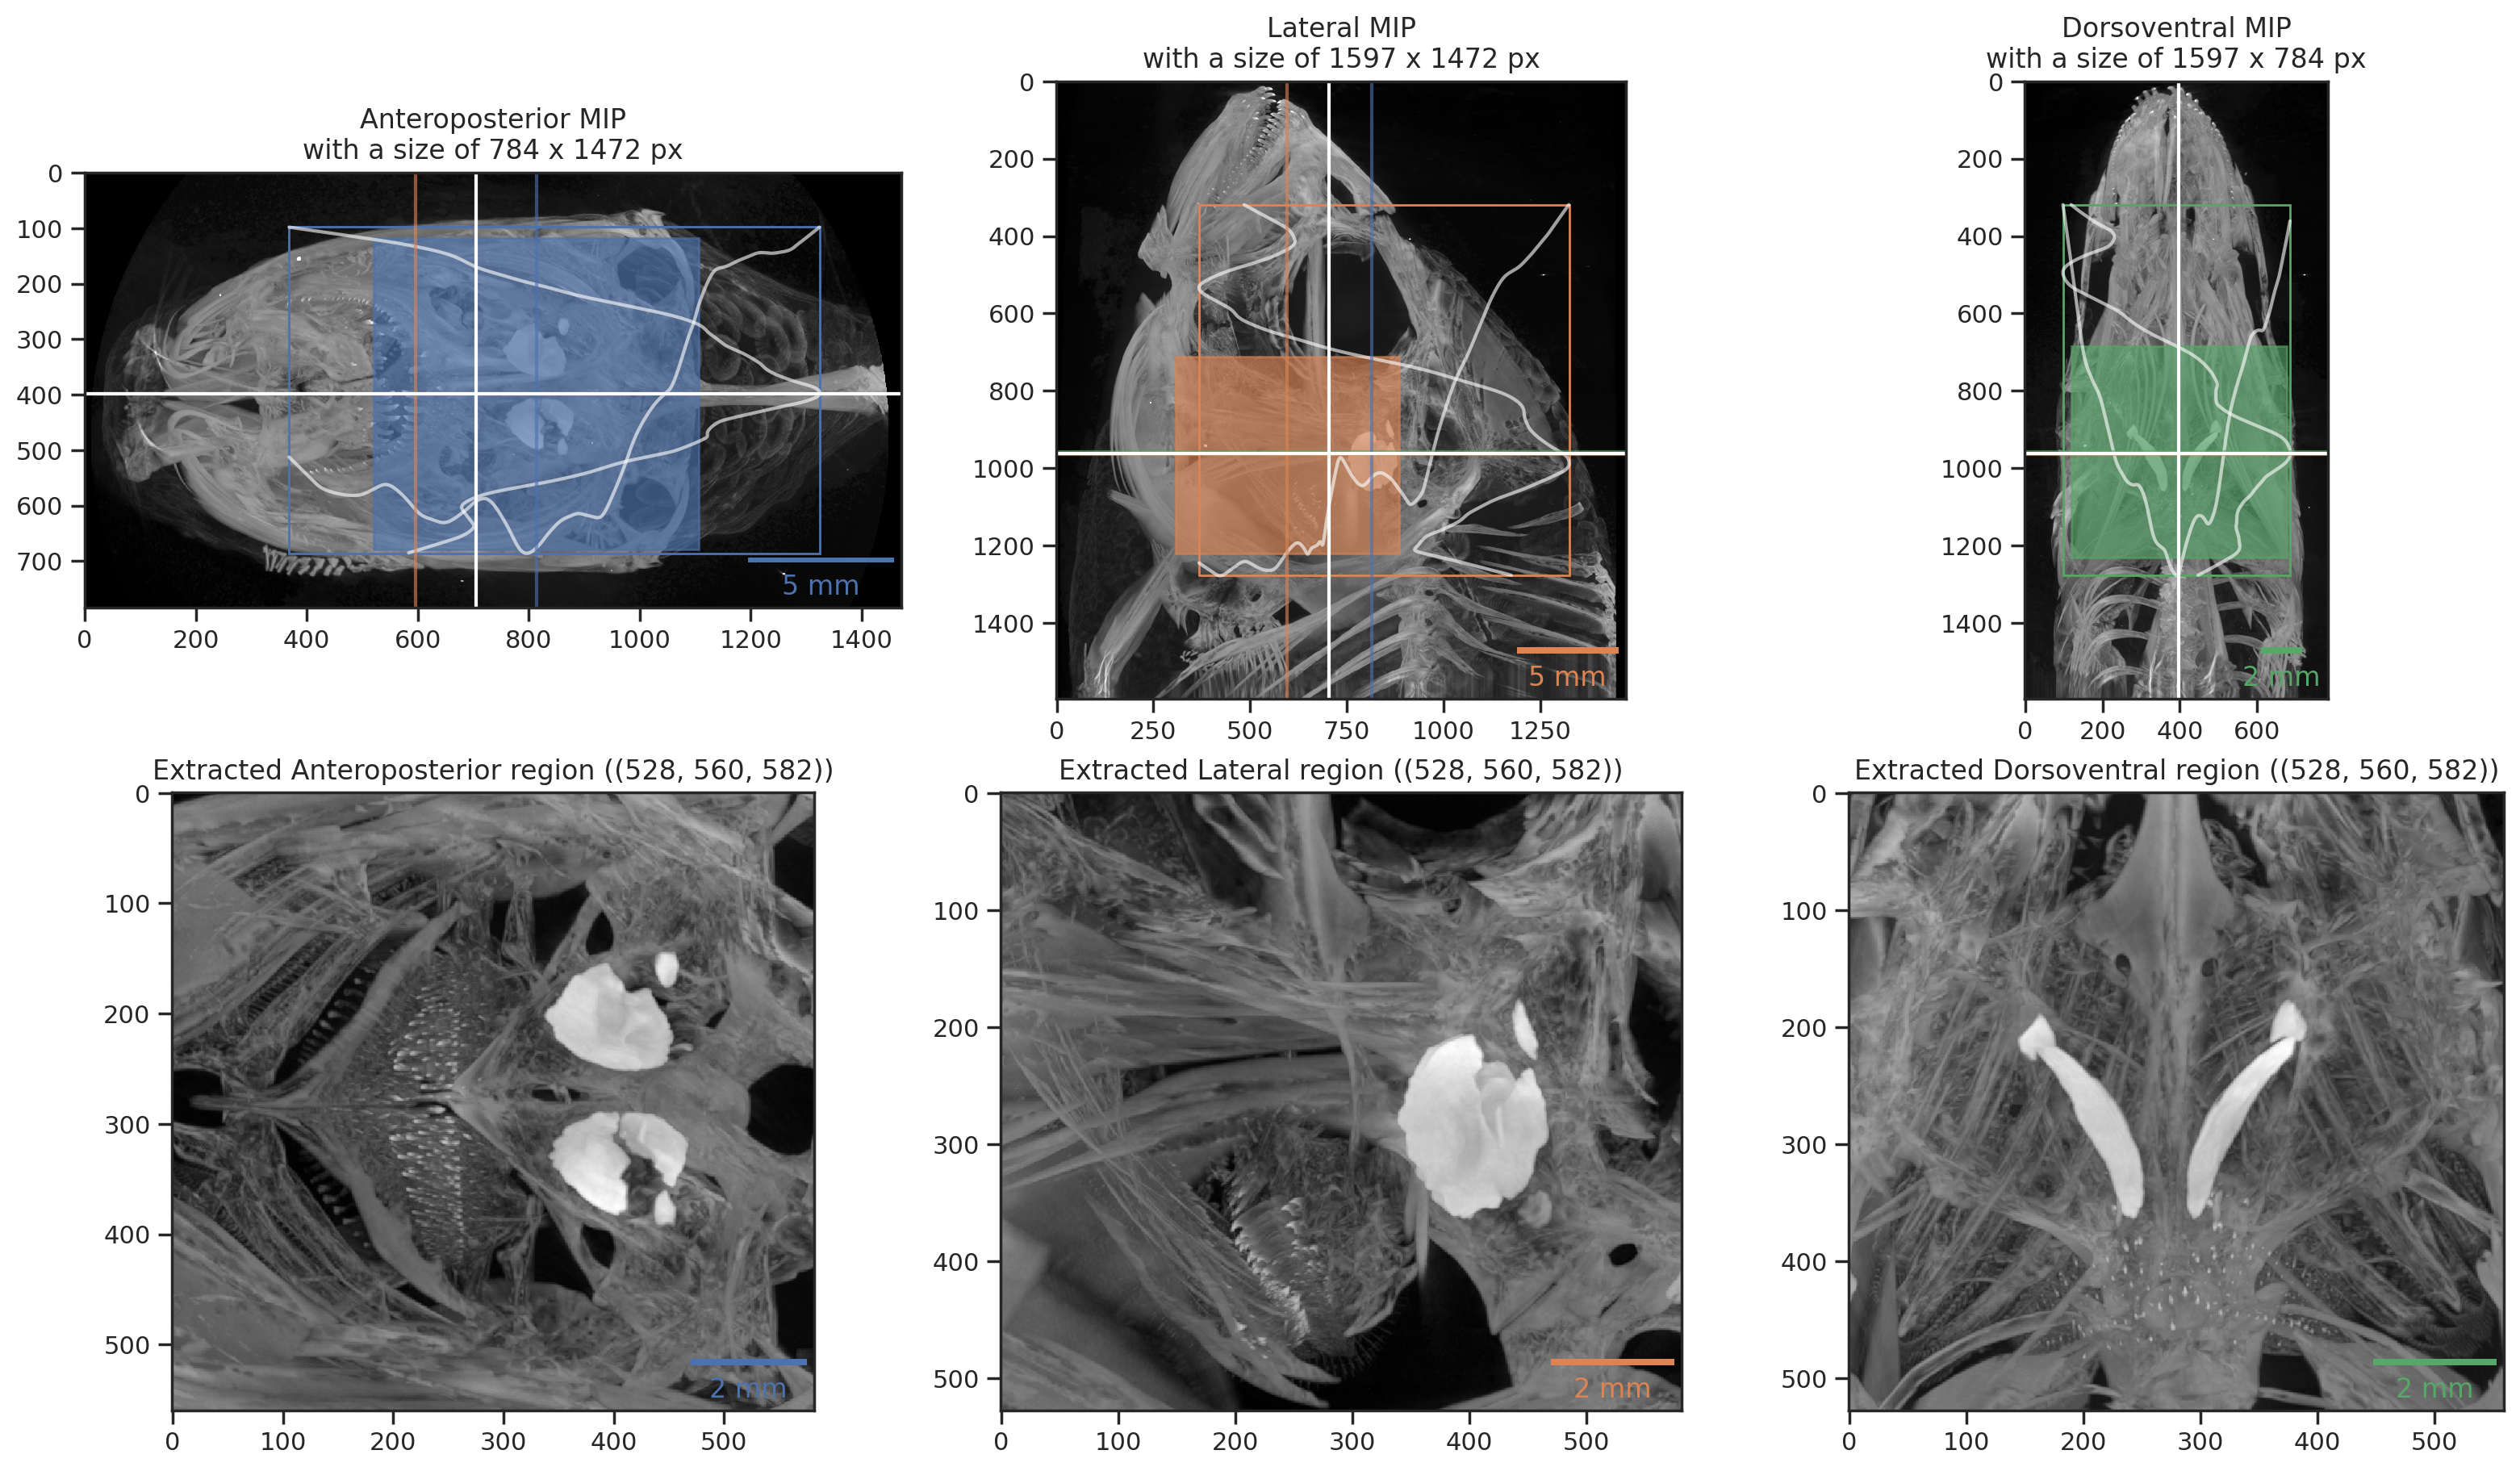

()

In [573]:
display_otolith_position(whichone)

In [574]:
def baller(image, center, ball_diameter, verbose=True):
    # From SubMyocardAnalysis.ipynb in Neoangiogenesis project
    '''
    Cut out a spherical region at a defined coordinate
    Save out both the small cutout region and the cutout region masked into the orignal size stack
    '''
    if verbose:
        print('Center', center)
    if len(image.shape) != len(center):
        print('We need three coordinates for the center')
    # First, get a cubic cutout from the original image
    cutout = image[center[0] - round(ball_diameter / 2):center[0] + round(ball_diameter / 2),
                   center[1] - round(ball_diameter / 2):center[1] + round(ball_diameter / 2),
                   center[2] - round(ball_diameter / 2):center[2] + round(ball_diameter / 2)]
    # Generate us a 'ball' mask
    ball = skimage.morphology.ball(cutout.shape[0]-1//2, dtype='bool')
    cutout *= ball
    if verbose:
        plt.subplot(231)
        plt.imshow(image[center[0]])
        plt.scatter(center[2], center[1], marker='x', color='w')
        
        plt.gca().add_artist(plt.Circle((center[2], center[1]), round(ball_diameter / 2), fill=False, color='w', label='Cutout'))
        plt.title('AP slice %s' % center[0])
        plt.subplot(232)
        plt.imshow(image[:,center[1],:])
        plt.scatter(center[2], center[0], marker='x', color='w')
        
        plt.gca().add_artist(plt.Circle((center[2], center[0]), round(ball_diameter / 2), fill=False, color='w', label='Cutout'))
        plt.title('LT slice %s' % center[1])
        plt.subplot(233)        
        plt.imshow(image[:,:,center[2]])
        plt.scatter(center[2], center[0], marker='x', color='w')
        plt.gca().add_artist(plt.Circle((center[1], center[0]), round(ball_diameter / 2), fill=False, color='w', label='Cutout'))        
        plt.title('DV slice %s' % center[2])
        
        for c, direction in enumerate(directions):
            plt.subplot(2,3,4+c)
            plt.imshow(cutout.max(axis=c))
        plt.show()
    
    # Get (cuboid) cutout region from original image and mask this cutout with the ball to have a sphere
    # try:
    #     cutout = None
    #     cutout = VOIs[whichone][Data.Midpoint[whichone][0] - ball_radius_px:Data.Midpoint[whichone][0] - ball_radius_px + ball.shape[0],
    #                             Data.Midpoint[whichone][2] - ball_radius_px:Data.Midpoint[whichone][2] - ball_radius_px + ball.shape[0],
    #                             Data.Midpoint[whichone][1] - ball_radius_px:Data.Midpoint[whichone][1] - ball_radius_px + ball.shape[0]]
    # except IndexError:
    #     print('Probably not working on a m_s_p VOI (e.g. %s), bailing out' % Data['VOI'][whichone])
    #     return()              
    # cutout *= ball
    # # Paste this cutout into an empty image at the correct position
    # empty = dask.array.zeros_like(VOIs[whichone])
    # # Make a 'noisy' empty image, so we better see what we do
    # # empty = dask.array.random.random(size=VOIs[whichone].shape) * 255
    # empty[Data.Midpoint[whichone][0] - radius_px:Data.Midpoint[whichone][0] - radius_px + ball.shape[0],
    #       Data.Midpoint[whichone][2] - radius_px:Data.Midpoint[whichone][2] - radius_px + ball.shape[0],
    #       Data.Midpoint[whichone][1] - radius_px:Data.Midpoint[whichone][1] - radius_px + ball.shape[0]] = cutout
    # # Generate output names and save the images to zarr files
    # Data.at[whichone, 'OutputNameCutout'] = os.path.join(os.path.dirname(Data.Folder[whichone]),
    #                                                      '%s_%s_voi_%s.cutout.at.%04d.%04d.%04d.radius.%sum.zarr' % (Data.Sample[whichone],
    #                                                                                                                  Data.Scan[whichone],
    #                                                                                                                  Data.VOI[whichone],
    #                                                                                                                  Data.Midpoint[whichone][0],
    #                                                                                                                  Data.Midpoint[whichone][1],
    #                                                                                                                  Data.Midpoint[whichone][2],
    #                                                                                                                  ball_radius_um))
    # Data.at[whichone, 'OutputNameMasked'] = Data.at[whichone, 'OutputNameCutout'].replace('cutout','masked')
    # if verbose:
    #     print('Saving cutout to %s' % Data['OutputNameCutout'][whichone])
    # if not os.path.exists(Data['OutputNameCutout'][whichone]):
    #     cutout.rechunk('auto').to_zarr(Data['OutputNameCutout'][whichone],
    #                                    overwrite=True,
    #                                    compressor=Blosc(cname='zstd',
    #                                                     clevel=9,
    #                                                     shuffle=Blosc.BITSHUFFLE))
    # if verbose:
    #     print('Saving cutout to %s' % Data['OutputNameMasked'][whichone])
    # if not os.path.exists(Data['OutputNameMasked'][whichone]):
    #     empty.rechunk('auto').to_zarr(Data['OutputNameMasked'][whichone],
    #                                   overwrite=True,
    #                                   compressor=Blosc(cname='zstd',
    #                                                    clevel=9,
    #                                                    shuffle=Blosc.BITSHUFFLE))
    # if verbose:
    #     # Let's see what we did there!
    #     plt.subplot(121)
    #     plt.imshow(cutout[cutout.shape[0]//2])
    #     plt.title('Middle cutout slice')
    #     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    #     plt.axis('off')
    #     plt.subplot(122)
    #     plt.imshow(VOIs[whichone][Data.Midpoint[whichone][0]])
    #     plt.scatter(Data.Midpoint[whichone][1], Data.Midpoint[whichone][2], color='red')
    #     plt.imshow(dask.array.ma.masked_equal(empty[Data.Midpoint[whichone][0]], 0),
    #                vmax=55,
    #                alpha=0.618,
    #                cmap='viridis')        
    #     plt.title('Full cutout shown over original')
    #     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    #     plt.axis('off')        
    #     plt.show()
    return(cutout)

In [575]:
# baller(Reconstructions[whichone],
#        (Data['Otolith_Peak_Anteroposterior_fish'][whichone],
#         Data['Otolith_Peak_Lateral_fish'][whichone],
#         Data['Otolith_Peak_Dorsoventral_fish'][whichone]),
#        Data['Otolith_Sphere_Diameter_fish'][whichone],
#       verbose=False)

In [576]:
# for direction in directions:
#     for view in views:
#         print(direction, view, 'peak', Data['Otolith_Peak_' + direction + '_' + view][whichone])

In [577]:
# for direction in directions:
#     for view in views:
#         print(direction, view, 'width', Data['Otolith_Width_' + direction + '_' + view][whichone])

In [ ]:
for whichone, row in tqdm(Data.iterrows(),
                          desc='Extracting otolith regions',
                          total=len(Data)):
    otolither_region(whichone, verbose=False)

Extracting otolith regions:   0%|          | 0/97 [00:00<?, ?it/s]

In [ ]:
items = 0
for whichone, row in tqdm(Data.iterrows(),
                          desc='Displaying otolith regions',
                          total=len(Data)):
    if whichone > items and whichone < items + 10:
        print(80*'-')
        print(whichone, row.Fish, row.Scan)
        display_otolith_position(whichone)

In [ ]:
# Save out otolith regions as .zarr files
# Construct output file name
Data['OutputNameOtolithRegion'] = [os.path.join(os.path.dirname(f), 'otolith.region.zarr') for f in Data['Folder']]
# Replace otolith 'center' into name
Data['OutputNameOtolithRegion'] = [n.replace('.region', '.at.%04d.%04d.%04d' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                      Data['Otolith_Peak_Anteroposterior_fish'],
                                                                                                                      Data['Otolith_Peak_Lateral_fish'],
                                                                                                                      Data['Otolith_Peak_Dorsoventral_fish'])]
# Replace otlith width into name
Data['OutputNameOtolithRegion'] = [n.replace('.zarr', '.size.%04d.%04d.%04d.zarr' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                             Data['Otolith_Width_Anteroposterior_fish'],
                                                                                                                             Data['Otolith_Width_Lateral_fish'],
                                                                                                                             Data['Otolith_Width_Dorsoventral_fish'])]
# Actually save the regions out now
for whichone, row in tqdm(Data.iterrows(),
                          desc='Extracting otolith regions to .zarr files',
                          total=len(Data)):
    if not os.path.exists(row['OutputNameOtolithRegion']):
        Reconstructions[whichone][Data['Otolith_Peak_Anteroposterior_fish'][whichone] - round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2):
                                  Data['Otolith_Peak_Anteroposterior_fish'][whichone] + round(Data['Otolith_Width_Anteroposterior_fish'][whichone] / 2),
                                  Data['Otolith_Peak_Lateral_fish'][whichone] - round(Data['Otolith_Width_Lateral_fish'][whichone] / 2):
                                  Data['Otolith_Peak_Lateral_fish'][whichone] + round(Data['Otolith_Width_Lateral_fish'][whichone] / 2),
                                  Data['Otolith_Peak_Dorsoventral_fish'][whichone] - round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2):
                                  Data['Otolith_Peak_Dorsoventral_fish'][whichone] + round(Data['Otolith_Width_Dorsoventral_fish'][whichone] / 2),
                                 ].to_zarr(row['OutputNameOtolithRegion'],
                                           overwrite=True,
                                           compressor=Blosc(cname='zstd',
                                                            shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load the otoliths in again
Otoliths = [dask.array.from_zarr(file) for file in Data['OutputNameOtolithRegion']]

In [74]:
asdfasdfasdf==

SyntaxError: invalid syntax (662306515.py, line 1)

In [ ]:
whichone=12
o = Otoliths[whichone]

In [ ]:
Otoliths[whichone].max().compute()

In [ ]:
Otoliths[whichone].mean().compute()

In [ ]:
Otoliths[whichone].min().compute()

In [ ]:
o.shape

In [ ]:
img = o[:,:,750].compute()
plt.imshow(img)
plt.show()

In [ ]:
# Plot histogramh,b = dask.array.histogram(o, bins=2**8, range=(0,2**8))
plt.semilogy(h)
# Caldulate multiotsu threshold and show them
for t in skimage.filters.threshold_multiotsu(o.compute(), classes=5):
    plt.axvline(t, label=t, c='red')
plt.xlim([0,2**8])
plt.legend()

In [ ]:
def segmentor(image, peaks, verbose=False):
    # https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html#sphx-glr-auto-examples-segmentation-plot-random-walker-segmentation-py
    # Set the background/discarded pixels to -1, 'stuff to be segmented' 0 and markers to 1
    # the details given on https://scipy-lectures.org/packages/scikit-image/index.html?highlight=random%20walker#random-walker-segmentation
    # Set everything to unlabeled
    if not len(peaks):
        print('Also give us some peaks to work with')
        print('skimage.filters.threshold_multiotsu(STACK.compute(), classes=5) is a good start')
        return()
    markers = numpy.zeros_like(image, dtype='uint8')
    # Set everything below background to be discarded.
    # This is the same as above
    if verbose:
        print('Discarding everything below %s' % peaks[1])
    markers[image < peaks[1]] = -1
    if verbose:
        print('Setting everything between %s and %s to 1' % (peaks[1], peaks[2]))
    markers[(image > peaks[1]) & (image < peaks[2])] = 1
    if verbose:
        print('Setting everything above %s to 2' % peaks[3])
    markers[image > peaks[3]] = 2
    # Do the segmentation now
    labels = random_walker(image.astype('uint8'), markers, copy=False)
    if verbose:
        # markers = markers.compute()
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        # plt.imshow(dask.array.ma.masked_where(-1, markers),
        #            cmap='viridis',
        #            alpha=0.5)
        plt.title('Original')
        plt.axis('off')      
        plt.subplot(2, 3, 2)
        plt.imshow(markers)
        plt.title('Markers')
        plt.axis('off')
        plt.subplot(2, 3, 3)
        plt.imshow(labels)
        plt.title('Labels')        
        plt.axis('off')            
        for c, value in enumerate(numpy.unique(markers)):
            plt.subplot(2, len(numpy.unique(markers)), len(numpy.unique(markers)) + c + 1)
            plt.imshow(image)
            plt.imshow(dask.array.ma.masked_not_equal(markers, value),
                       cmap='viridis_r')
            plt.title('%s=%s' % (c, value))
            plt.axis('off')
        plt.show()
    # Return labeled image as an interpolated 8bit image
    print(numpy.unique(markers))    
    print(numpy.unique(labels))
    return(numpy.interp(labels, (labels.min(), labels.max()), (labels.min(), 255)).astype('uint8'))

In [ ]:
# peaks=skimage.filters.threshold_multiotsu(o.compute(), classes=5)
print(peaks)

In [ ]:
mask = segmentor(o[:,:,800].compute(),
                 peaks,
                 verbose=True)

In [ ]:
numpy.unique(mask)

In [ ]:
plt.imshow(o[:,:,800])
plt.imshow(mask,
           alpha=0.309,
           cmap='viridis')

In [ ]:
asdfasdfasdfasdf==

In [ ]:
mask.shape()

In [ ]:
numpy.unique(mask)

In [ ]:
# View one otolith in 3D

In [ ]:
whichone = 0

In [ ]:
subsample = 3

In [ ]:
# threshold = threshold(Otoliths[whichone], verbose=False)
# histogram = histogram(Otoliths[whichone])

In [ ]:
mask.shape

In [ ]:
plt.semilogy(histogram)
plt.axvline(threshold, label='Threshold @%s' % threshold)
plt.legend()
plt.show()

In [ ]:
# Load into K3D
# plt_volume = k3d.volume(Otoliths[whichone][::subsample,::subsample,::subsample].astype(numpy.float16), color_range=[threshold,Otoliths[whichone].max().compute()])
plt_volume = k3d.volume((Otoliths[whichone][::subsample,::subsample,::subsample]>peaks[-1]).astype(numpy.float16))

In [ ]:
# Display the otolith
plot = k3d.plot()
plot += plt_volume
plot.display()

In [ ]:
asdfasdfsda=

In [ ]:
# plot5 = k3d.get_plot()
# plot5.snapshot_type = 'inline'
# plot5.display()

# data = plot5.get_snapshot()

# with open('snapshot_inline.html', 'w') as f:
#     f.write(data)

In [ ]:
for c, row in Data.iterrows():
    print(row.Fish, row.Folder)
    otolither_region(c, verbose=True)

In [ ]:
whichone = 5
out = Reconstructions[5][716:1009+716-500,300:-300,800:1000]

In [ ]:
out.shape

In [ ]:
plt.imshow(out.max(axis=0))

In [ ]:
# Make a column for saving the otolith positions
for d, direction in enumerate(directions):
    Data['Otholith_Positions_' + direction] = ''
    Data['Otholith_Position_Mean_' + direction] = ''

In [ ]:
# Detect otolith positions
for c, row in Data.iterrows():
    print('Finding otolith position for %s/%s' % (row.Fish, row.Scan))
    for d, direction in enumerate(directions):
        Data.at[c, 'Otholith_Positions_' + direction] = otolither(row['MIP_' + direction], sigma=11, verbose=True)

In [ ]:
# Save us the mean position
for d, direction in enumerate(directions):
    Data['Otholith_Position_Mean_' + direction] = [(numpy.mean(op[0]),
                                                    numpy.mean(op[1])) for op in Data['Otholith_Positions_' + direction]]

In [ ]:
for i in Data['Otholith_Positions_Lateral']:
    print(round(numpy.mean(i[0])),
          round(numpy.mean(i[1])))

In [ ]:
for i in Data['Otholith_Position_Mean_Lateral']:
    print(round(i[0]), round(i[1]))

In [ ]:
for whichone in range(len(Data)):
    print(whichone, os.path.join(Data.Fish[whichone], Data.Scan[whichone]))

In [ ]:
direction = 'Lateral'

In [ ]:
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.title([round(i) for i in row['Otholith_Position_Mean_' + direction]])
        plt.axhline(row['Otholith_Position_Mean_' + direction][1])
        plt.axvline(row['Otholith_Position_Mean_' + direction][0])
        plt.suptitle('%s/%s' % (row.Fish, row.Scan))
        plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
    plt.show()

In [ ]:
# Detect otolith position by looking for maximum gray value along fish
for d, direction in enumerate(directions):
    Data['GrayValueAlong_' + direction] = ''
    Data['Otolith_MIP_Position_' + direction] = ''
for whichone, row in Data.iterrows():
    for d, direction in enumerate(directions):
        # Calculate gray value sum along fish.
        Data.at[whichone, 'GrayValueAlong_' + direction] = dask.array.sum(Data['MIP_' + direction][whichone],
                                                                          axis=1)
        # Maximum of this shoud give us the otolith position
        Data.at[whichone,
                'Otolith_MIP_Position_' + direction] = dask.array.argmax(dask.array.sum(Data['MIP_' + direction][whichone],
                                                                                        axis=1))
        # Plot what we found
        plt.subplot(1, 3, d + 1)
        plt.imshow(Data['MIP_' + direction][whichone])
        # Plot the *rescaled* values over the image
        plt.plot(rescale_linear(Data['GrayValueAlong_' + direction][whichone],
                                100,
                                Data['MIP_' + direction][whichone].shape[1] - 100),
                 range(len(Data['GrayValueAlong_' + direction][whichone])),
                 label='Normalized gray value sum along fish',
                 color=seaborn.color_palette()[0])
        plt.axhline(Data['Otolith_MIP_Position_' + direction][whichone],
                    label='Max@%s' % Data['Otolith_MIP_Position_' + direction][whichone].compute(),
                    color=seaborn.color_palette()[1])
        plt.title('%s MIP' % direction)
        plt.suptitle('%s/%s: MIPs of %s/%s' % (whichone, len(Data), Data.Fish[whichone], Data.Scan[whichone]))
        plt.legend(loc='lower center')
    plt.show()

In [ ]:
for c, row in Data.iterrows():
    print(c, len(Data), os.path.join(row.Fish, row.Scan))
    print('\t Otolith from MIP',
          row['Otolith_MIP_Position_Anteroposterior'].compute(),
          row['Otolith_MIP_Position_Lateral'].compute(),
          row['Otolith_MIP_Position_Dorsoventral'].compute())
    print('\t Otolith from otholither function',
          row['Otholith_Position_Mean_Anteroposterior'],
          row['Otholith_Position_Mean_Lateral'],
          row['Otholith_Position_Mean_Dorsoventral'])

In [ ]:
whichone = 3

In [ ]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(Data['MIP_' + direction][whichone])
    # From otholither function
    plt.axhline(Data['Otholith_Position_Mean_' + direction][whichone][1],
                label='otholither mean position 1: %s' % round(Data['Otholith_Position_Mean_' + direction][whichone][1]),
                color=seaborn.color_palette()[0])
    plt.axvline(Data['Otholith_Position_Mean_' + direction][whichone][0],
                label='otholither mean posistion 0: %s' % round(Data['Otholith_Position_Mean_' + direction][whichone][0]),
                color=seaborn.color_palette()[1])
    # From sum along axis
    plt.axhline(Data['Otolith_MIP_Position_' + direction][whichone],
                label='MIP sum: %s' % Data['Otolith_MIP_Position_' + direction][whichone].compute(),
                color=seaborn.color_palette()[3])
    plt.legend(loc='lower center')
    plt.title(direction)
    plt.suptitle('%s/%s' % (Data.Fish[whichone], Data.Scan[whichone]))
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um'))
plt.show()

In [ ]:
for direction in directions:
    print(direction, Data['MIP_' + direction][whichone].shape)

In [ ]:
for direction in directions:
    print(direction, Data['Otholith_Position_Mean_' + direction][whichone])

In [ ]:
for direction in directions:
    print(direction, round(Data['Otolith_MIP_Position_' + direction][whichone].compute()))

In [ ]:
# CAN WE CALCULATE BOTH DV and THE LT POSITION ON THE AP MIP?

In [ ]:
# Get us positions of otolith in relation to original data
position_ap = numpy.mean((Data['Otholith_Position_Mean_Lateral'][whichone][1],
                          Data['Otholith_Position_Mean_Dorsoventral'][whichone][1],
                          Data['Otolith_MIP_Position_Lateral'][whichone],
                          Data['Otolith_MIP_Position_Dorsoventral'][whichone]),
                         dtype='int')
# laterally, we assume the center of the image for now
# position_lt = numpy.mean((Data['Otholith_Position_Mean_' + direction][whichone][1],
#                           Data['Otolith_MIP_Position_' + direction][whichone]),dtype='int')
position_lt = Data.MIP_Dorsoventral[whichone].shape[1] // 2
position_dv = numpy.mean((Data['Otholith_Position_Mean_Anteroposterior'][whichone][0],
                          Data['Otholith_Position_Mean_Lateral'][whichone][0]),
                         dtype='int')

In [ ]:
print(position_ap)
print(position_lt)
print(position_dv)

In [ ]:
slicethickness = 250

In [ ]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(Data['MIP_' + direction][whichone])
    if c == 0:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_lt - slicethickness // 2,
                         position_lt + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_dv - slicethickness // 2, position_dv + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    elif c == 1:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_ap - slicethickness // 2,
                         position_ap + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_dv - slicethickness // 2, position_dv + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    else:
        plt.fill_between(range(Data['MIP_' + direction][whichone].shape[1]),
                         position_ap - slicethickness // 2,
                         position_ap + slicethickness // 2,
                         alpha=0.5)
        plt.fill_between(range(position_lt - slicethickness // 2, position_lt + slicethickness // 2),
                         1,
                         Data['MIP_' + direction][whichone].shape[0] - 1,
                         alpha=0.5)
    plt.title(direction)
    plt.suptitle('%s/%s' % (Data.Fish[whichone], Data.Scan[whichone]))
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um'))
    
outfilepath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                           '%s.%s.Otolither.png' % (Data['Fish'][whichone], Data['Scan'][whichone]))
if not os.path.exists(outfilepath):
    plt.savefig(outfilepath,
                oarent=True,
                bbox_inches='tight')
    print('Figure saved to %s' % outfilepath)
plt.show()

In [ ]:
print(position_ap)
print(position_lt)
print(position_dv)

In [ ]:
# Grab region calculated above from reconstructions
otolithregion = Reconstructions[whichone][position_ap - slicethickness // 2:position_ap + slicethickness // 2,
                                          position_lt - slicethickness // 2:position_lt + slicethickness // 2,
                                          position_dv - slicethickness // 2:position_dv + slicethickness // 2
                                         ]
for ax in range(3):
    plt.subplot(1, 3, ax + 1)
    plt.imshow(dask.array.max(otolithregion, axis=ax))
    plt.suptitle('%s/%s: MIP from AP %s:%s, LT %s:%s, DV %s:%s' % (Data.Fish[whichone],
                                                                   Data.Scan[whichone],
                                                                   position_ap - slicethickness // 2, position_ap + slicethickness // 2,
                                                                   position_lt - slicethickness // 2, position_lt + slicethickness // 2,
                                                                   position_dv - slicethickness // 2, position_dv + slicethickness // 2))
plt.show()

In [ ]:
threshold(otolithregion.compute())

In [ ]:
threshold(otolithregion[otolithregion > 42].compute())

In [ ]:
plt.imshow(otolithregion[slicethickness//2])
plt.imshow(dask.array.ma.masked_equal(otolithregion[slicethickness//2] > 102,0), cmap='viridis', alpha=0.5)

In [ ]:
# import pickle

In [ ]:
# file = open('largest', 'wb')
# pickle.dump(largest,file)
# file.close()

In [ ]:
# file = open('largest', 'rb')
# largest = pickle.load(file)
# file.close()

In [ ]:
# largest.shape

In [ ]:
# # Make file smaller for testing reasons
# subsample = 4
# largest_smaller = largest[::subsample, ::subsample, ::subsample]
# largest_smaller.shape

In [ ]:
subsample = 2

In [ ]:
vmin = threshold(otolithregion.compute())
print(vmin)

In [ ]:
# Load into K3D
plt_volume = k3d.volume(dask.array.ma.masked_less(otolithregion,102)[::subsample, ::subsample, ::subsample].astype(numpy.float16))

In [ ]:
# Display the otolith
plot = k3d.plot()
plot += plt_volume
plot.display()    

In [ ]:
# plot5 = k3d.get_plot()
# plot5.snapshot_type = 'inline'
# plot5.display()

# data = plot5.get_snapshot()

# with open('snapshot_inline.html', 'w') as f:
#     f.write(data)